In [2]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import math
from scipy.stats import norm
import joblib
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from core.dataset import PSMDataset
from core.model import GalSpecNet, MetaModel, Informer, AstroM3
from core.trainer import Trainer

In [3]:
def get_model(config):
    if config['mode'] == 'photo':
        model = Informer(config)
    elif config['mode'] == 'spectra':
        model = GalSpecNet(config)
    elif config['mode'] == 'meta':
        model = MetaModel(config)
    else:
        model = AstroM3(config)

    return model

def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

def get_centers(p_emb, s_emb, m_emb, train_labels):
    p_centers, s_centers, m_centers, all_centers = [], [], [], []

    for i in range(10):
        ind = train_labels == i
    
        p_center = p_emb[ind].mean(axis=0)
        p_center = p_center / p_center.norm()
        p_centers.append(p_center)
    
        s_center = s_emb[ind].mean(axis=0)
        s_center = s_center / s_center.norm()
        s_centers.append(s_center)
    
        m_center = m_emb[ind].mean(axis=0)
        m_center = m_center / m_center.norm()
        m_centers.append(m_center)

        all_emb = (p_emb + s_emb + m_emb) / 3
        all_center = all_emb[ind].mean(axis=0)
        all_center = all_center / all_center.norm()
        all_centers.append(all_center)
    
    p_centers = torch.stack(p_centers)
    s_centers = torch.stack(s_centers)
    m_centers = torch.stack(m_centers)
    all_centers = torch.stack(all_centers)

    return p_centers, s_centers, m_centers, all_centers

def plot_obj_umap(dataset, idx, embeddings, targets):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    l, b = id2lb[el['id']]
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))

    obj_embedding = embeddings[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    axs[0].plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    axs[1].plot(spectra[:, 0], spectra[:, 1], label='Spectra')
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        axs[2].scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                       color=palette[class_id], label=class_name, alpha=1.0, s=marker_size)

    axs[2].scatter(obj_embedding[0], obj_embedding[1], color=palette[targets[idx]], edgecolors='black', alpha=1.0, s=5 * marker_size)
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    axs[2].legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    
    
    plt.suptitle(f'period = {period}    label = {id2target[label]}     idx {idx}    L = {l}    B = {b}    id {el["id"]}')
    plt.tight_layout()
    plt.show()


def plot_one_embs_period(embeddings, periods):
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=periods, cmap='viridis', s=marker_size, alpha=1.0)
    plt.colorbar(sc, label='Period')
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [4]:
org_train = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
org_val = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')
org_test = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

org_train = org_train[['id', 'l', 'b']]
org_val = org_val[['id', 'l', 'b']]
org_test = org_test[['id', 'l', 'b']]

combined_df = pd.concat([org_train, org_val, org_test])
id2lb = combined_df.set_index('id')[['l', 'b']].T.to_dict('list')

run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False

model = get_model(config)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [5]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'

train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

val_dataset = PSMDataset(config, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
val_p_emb, val_s_emb, val_m_emb, val_labels = get_embs(val_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

p_centers, s_centers, m_centers, all_centers = get_centers(train_p_emb, train_s_emb, train_m_emb, train_labels)

train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
val_emb = (val_p_emb + val_s_emb + val_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

umap = joblib.load('umap.pkl')
train_umap = umap.transform(train_emb)
val_umap = umap.transform(val_emb)
test_umap = umap.transform(test_emb)

100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.09s/it]


In [6]:
id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("Spectral", len(id2target))
palette[3], palette[-4] = palette[-4], palette[3] 
palette[1], palette[-2] = palette[-2], palette[1] 

In [7]:
train_period = np.array(train_dataset.df['org_period'])

In [9]:
cls = joblib.load('rot-classes.pkl')
ids = train_dataset.df[train_dataset.df['target'] == 'ROT'][['id']]
ids['gaia_label'] = 'no-label'

for idx, label in cls.items():
    ids.loc[ids['id'] == 'EDR3 ' + idx, 'gaia_label'] = label

gaia_labels = np.array(ids['gaia_label'])
unique_labels = np.unique(gaia_labels)
num_labels = len(unique_labels)

gaia_id2target = {i: unique_labels[i] for i in range(len(unique_labels))}
gaia_target2id = {unique_labels[i]: i for i in range(len(unique_labels))}

rot_umap = train_umap[train_labels == target2id['ROT']]
rot_palette = sns.color_palette("Spectral", len(unique_labels))

NameError: name 'cls' is not defined

In [ ]:
num_cols = (num_labels + 1) // 2
fig, axes = plt.subplots(2, num_cols, figsize=(15, 8))
fig.suptitle('Scatter Plots for Each Class')

x_min, x_max = rot_umap[:, 0].min() - 1, rot_umap[:, 0].max() + 1
y_min, y_max = rot_umap[:, 1].min() - 1, rot_umap[:, 1].max() + 1
axes = axes.flatten()

for ax, class_name in zip(axes, unique_labels):
    ind = gaia_labels == class_name
    other_ind = ~ind

    ax.scatter(rot_umap[other_ind, 0], rot_umap[other_ind, 1], color='gray', alpha=0.2, s=marker_size)
    ax.scatter(rot_umap[ind, 0], rot_umap[ind, 1], color=rot_palette[gaia_target2id[class_name]], label=class_name, alpha=1.0, s=marker_size, edgecolors='black', linewidth=0.5)
    ax.set_title(f'Class: {class_name}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()

for ax in axes[len(unique_labels):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [31]:
rot_periods = np.array(train_dataset.df[train_dataset.df['target'] == 'ROT'][['org_period']])

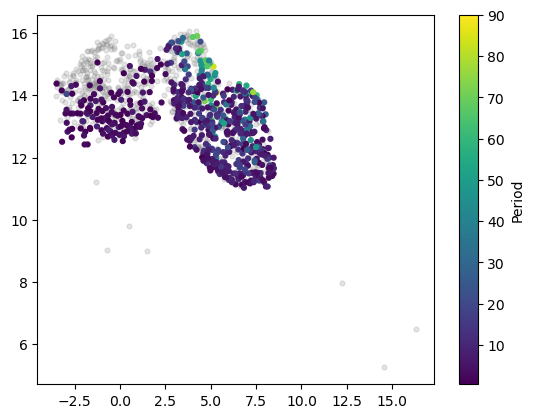

In [32]:
ind = gaia_labels == 'RS'
other_ind = ~ind

plt.scatter(rot_umap[other_ind, 0], rot_umap[other_ind, 1], color='gray', alpha=0.2, s=marker_size)
sc = plt.scatter(rot_umap[ind, 0], rot_umap[ind, 1], c=rot_periods[ind], cmap='viridis', alpha=1.0, s=marker_size)
plt.colorbar(sc, label='Period')

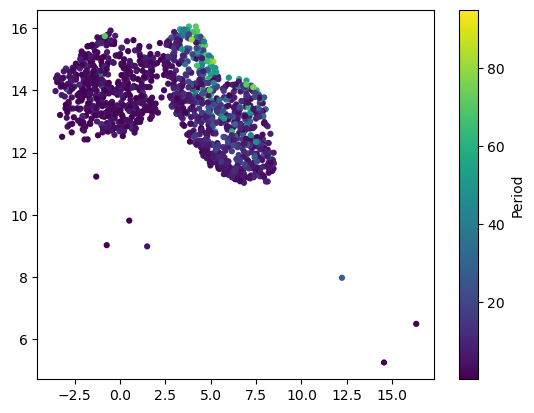

In [33]:
sc = plt.scatter(rot_umap[:, 0], rot_umap[:, 1], c=rot_periods, cmap='viridis', alpha=1.0, s=marker_size)
plt.colorbar(sc, label='Period')

In [34]:
train_labels == target2id['ROT']

tensor([False,  True, False,  ..., False, False, False])

In [15]:
rot_indices = np.where(train_labels == target2id['ROT'])[0]
rs_indices = rot_indices[np.where(gaia_labels == 'RS')[0]]

NameError: name 'gaia_labels' is not defined

In [36]:
rs_indices.shape

(587,)

In [37]:
rs_umap = train_umap[rs_indices]
rs_bin = np.where(rs_umap[:, 0] < 2.6, 1, 0)

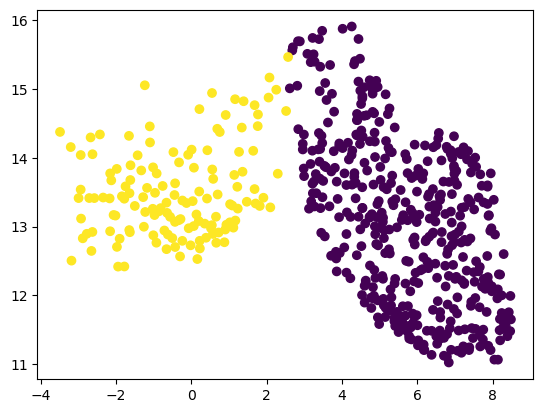

In [38]:
plt.scatter(rs_umap[:, 0], rs_umap[:, 1], c=rs_bin)

In [39]:
umap = joblib.load('umap.pkl')
p_umap = umap.transform(train_p_emb[rs_indices])
s_umap = umap.transform(train_s_emb[rs_indices])
m_umap = umap.transform(train_m_emb[rs_indices])

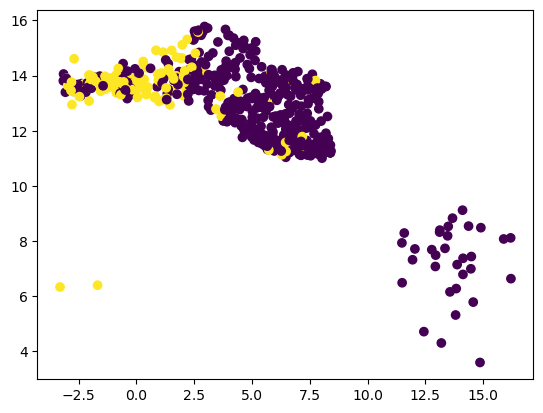

In [40]:
plt.scatter(p_umap[:, 0], p_umap[:, 1], c=rs_bin)

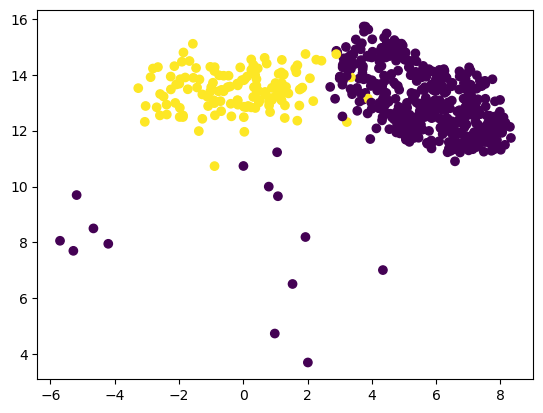

In [41]:
plt.scatter(s_umap[:, 0], s_umap[:, 1], c=rs_bin)

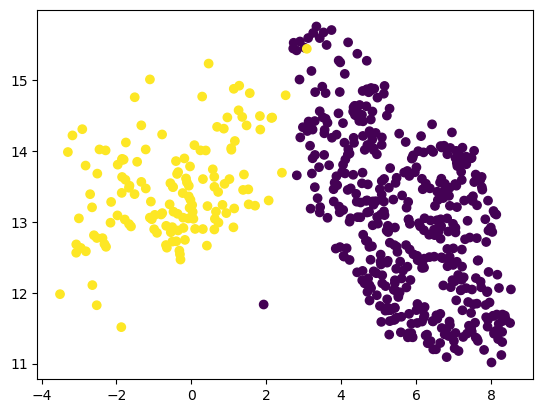

In [42]:
plt.scatter(m_umap[:, 0], m_umap[:, 1], c=rs_bin)

In [43]:
rs_umap = train_umap[rs_indices]
rs_bin_period = np.where(train_dataset.df.loc[rs_indices, 'org_period'] > 10, 1, 0)

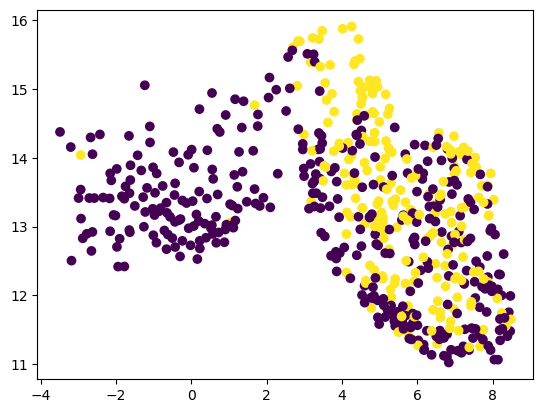

In [44]:
plt.scatter(rs_umap[:, 0], rs_umap[:, 1], c=rs_bin_period)

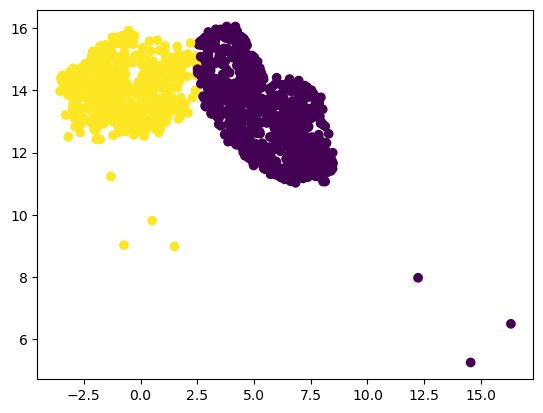

In [63]:
rot_indices = np.where(train_labels == target2id['ROT'])[0]
rot_umap = train_umap[rot_indices]
rot_bin = np.where(rot_umap[:, 0] < 2.5, 1, 0)
plt.scatter(rot_umap[:, 0], rot_umap[:, 1], c=rot_bin)

In [13]:
df = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')

In [ ]:
rot_df = df[df['id'].isin(train_dataset.df.iloc[rot_indices]['id'])]
rot_df = rot_df[train_dataset.meta_cols]

g_mag = rot_df['phot_g_mean_mag']  # Apparent magnitude in G band
bp_mag = rot_df['phot_bp_mean_mag']  # Apparent magnitude in BP band
rp_mag = rot_df['phot_rp_mean_mag']  # Apparent magnitude in RP band
parallax = rot_df['parallax']  # Parallax in milliarcseconds (mas)

# Convert parallax to distance in parsecs
distance_pc = 1000 / parallax  # Distance in parsecs

# Calculate absolute magnitude M_G
M_G = g_mag - 5 * np.log10(distance_pc) + 5

# Calculate color index G_BP - G_RP
color_index = bp_mag - rp_mag

plt.figure(figsize=(8, 6))
plt.scatter(color_index, M_G, c=rot_bin, marker='o', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis since brighter stars have lower magnitudes
plt.xlabel(r'Color Index $G_{BP} - G_{RP}$', fontsize=12)
plt.ylabel(r'Absolute Magnitude $M_G$', fontsize=12)
plt.title('Color-Magnitude Diagram (CMD)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
rs_df = df[df['id'].isin(train_dataset.df.iloc[rs_indices]['id'])]

NameError: name 'rs_indices' is not defined

In [48]:
rs_df = rs_df[train_dataset.meta_cols]

In [11]:
g_mag = rs_df['phot_g_mean_mag']  # Apparent magnitude in G band
bp_mag = rs_df['phot_bp_mean_mag']  # Apparent magnitude in BP band
rp_mag = rs_df['phot_rp_mean_mag']  # Apparent magnitude in RP band
parallax = rs_df['parallax']  # Parallax in milliarcseconds (mas)

# Convert parallax to distance in parsecs
distance_pc = 1000 / parallax  # Distance in parsecs

# Calculate absolute magnitude M_G
M_G = g_mag - 5 * np.log10(distance_pc) + 5

# Calculate color index G_BP - G_RP
color_index = bp_mag - rp_mag

NameError: name 'rs_df' is not defined

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(color_index, M_G, c=rs_bin, marker='o', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis since brighter stars have lower magnitudes
plt.xlabel(r'Color Index $G_{BP} - G_{RP}$', fontsize=12)
plt.ylabel(r'Absolute Magnitude $M_G$', fontsize=12)
plt.title('Color-Magnitude Diagram (CMD)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'color_index' is not defined

<Figure size 800x600 with 0 Axes>

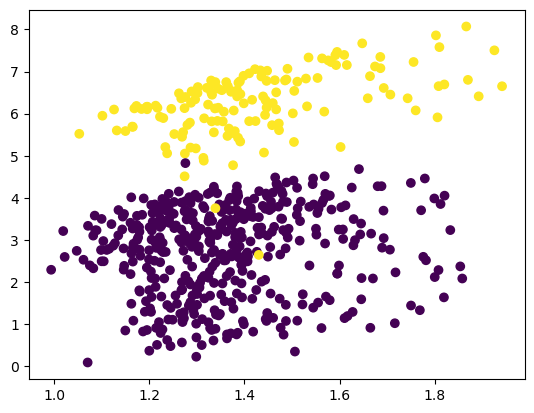

In [58]:
plt.scatter(color_index, M_G, c=rs_bin)

In [337]:
for el in train_dataset.df.loc[rs_indices[rs_bin == 0], 'name']:
    print(f"'{el[len('ASASSN-V'):]}',", end="")

'J121603.08+301338.0','J174320.27+241401.1','J085408.40-033408.9','J112552.07+592234.4','J000311.17+385513.2','J231126.95+313247.9','J140851.11-064309.9','J022754.58+431039.3','J063451.54+481645.5','J224856.14+190819.0','J104528.68+121657.3','J002025.23+384652.0','J072915.45+000029.5','J062917.16+181446.5','J065913.23+134133.2','J022859.96+374940.1','J211304.90+175928.0','J004054.25+314349.3','J001023.50+164852.0','J232322.30+291200.6','J233148.42+240127.2','J064304.60+604540.4','J231327.81+422012.5','J214509.17+040149.0','J152038.92+171858.3','J162313.37+523243.4','J155424.15+360405.8','J224521.19+462619.6','J011128.06+484752.6','J153943.37+174949.0','J082847.40+263343.1','J192917.28+372154.1','J220838.13+305248.6','J072959.78+393648.5','J091608.87+112328.7','J065956.39+392708.9','J025014.52+254629.7','J025517.85+234548.8','J224124.75+281046.7','J003601.98+343132.9','J074514.88+100010.7','J005839.09+363851.4','J004141.74+023315.9','J074911.94+413039.1','J042653.33+330506.0','J205545.7

In [220]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(rs_df, rs_bin)

DecisionTreeClassifier(random_state=42)

In [221]:
y_pred = clf.predict(rs_df)

In [224]:
(y_pred == rs_bin).sum() / len(rs_bin)

1.0

[Text(0.36666666666666664, 0.9166666666666666, 'parallax <= 1.984\ngini = 0.363\nsamples = 587\nvalue = [447, 140]\nclass = 0'),
 Text(0.13333333333333333, 0.75, 'parallax <= 1.738\ngini = 0.009\nsamples = 438\nvalue = [436, 2]\nclass = 0'),
 Text(0.25, 0.8333333333333333, 'True  '),
 Text(0.06666666666666667, 0.5833333333333334, 'gini = 0.0\nsamples = 427\nvalue = [427, 0]\nclass = 0'),
 Text(0.2, 0.5833333333333334, 'w3_w4 <= 2.296\ngini = 0.298\nsamples = 11\nvalue = [9, 2]\nclass = 0'),
 Text(0.13333333333333333, 0.4166666666666667, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = 0'),
 Text(0.26666666666666666, 0.4166666666666667, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = 1'),
 Text(0.6, 0.75, 'j_mag <= 9.913\ngini = 0.137\nsamples = 149\nvalue = [11, 138]\nclass = 1'),
 Text(0.4833333333333333, 0.8333333333333333, '  False'),
 Text(0.4666666666666667, 0.5833333333333334, 'ruwe <= 1.062\ngini = 0.198\nsamples = 9\nvalue = [8, 1]\nclass = 0'),
 Text(0.4, 0.4166666666666667

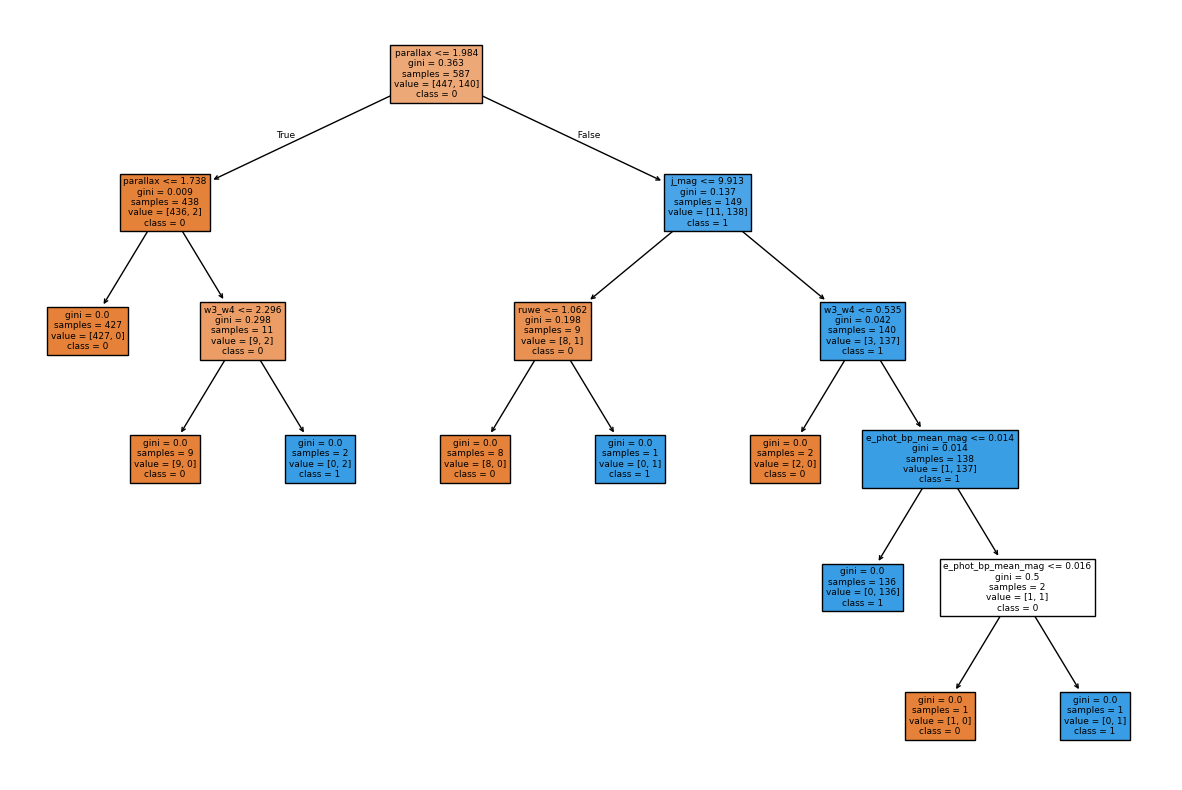

In [228]:
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=rs_df.columns, class_names=["0", "1"])

In [432]:
"""
Ca II H & K Lines (3968.5 Å & 3933.7 Å):
Indicators of chromospheric activity.
Emission reversals or filled-in absorption cores suggest high activity.
H-alpha Line (6562.8 Å):
Emission or filled-in absorption indicative of active chromospheres.
Ca II Infrared Triplet (8498 Å, 8542 Å, 8662 Å
"""
def plot_spectra_rs(dataset, idx):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    l, b = id2lb[el['id']]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))
    ax.plot(spectra[:, 0], spectra[:, 1], label='Spectra')

    # ax.axvspan(3933.7-1, 3933.7+1, color='red', alpha=1.0, label='Ca II H & K Lines (3968.5 Å & 3933.7 Å)')
    # ax.axvspan(3968.5-1, 3968.5+1, color='red', alpha=1.0, label='Ca II H & K Lines (3968.5 Å & 3933.7 Å)')
    
    # ax.axvspan(4101.7-1, 4101.7+1, color='cyan', alpha=1.0, label='Hδ 4101.7 Å')
    # ax.axvspan(4340.5-1, 4340.5+1, color='cyan', alpha=1.0, label='Hγ 4340.5 Å')
    # ax.axvspan(4861.3-1, 4861.3+1, color='cyan', alpha=1.0, label='Hβ 4861.3 Å')
    # ax.axvspan(6562.8-1, 6562.8+1, color='cyan', alpha=1.0, label='Hα 6562.8 Å')

    # ax.axvspan(4383-1, 4383+1, color='magenta', alpha=1.0, label='Fe I 4383 Å')
    # ax.axvspan(4957-1, 4957+1, color='magenta', alpha=1.0, label='Fe I 4957 Å')
    # ax.axvspan(5167-1, 5167+1, color='magenta', alpha=1.0, label='Fe I 5167 Å')
    # ax.axvspan(5328-1, 5328+1, color='magenta', alpha=1.0, label='Fe I 5328 Å')

    # ax.axvspan(4736, 4738, color='purple', alpha=1.0, label='C-type C2 Swan band 4737 Å')
    # ax.axvspan(5164, 5166, color='purple', alpha=1.0, label='C-type C2 Swan band 5165 Å')

    # ax.axvspan(5896-1, 5896+1, color='brown', alpha=1.0, label='Na I D1 5896 Å')

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
    ax.grid(True)

    plt.suptitle(f'period = {period}    label = {id2target[label]}     idx {idx}    L = {l}    B = {b}    id {el["id"]}')
    plt.tight_layout()
    plt.show()

In [413]:
rs_indices[rs_bin == 0][:5], rs_indices[rs_bin == 1][:5]

(array([ 5,  9, 12, 68, 69]), array([ 54,  81, 202, 586, 887]))

In [431]:
train_dataset.df.loc[rs_indices[rs_bin == 0], 'id']

5       EDR3 4013710404844589568
9       EDR3 4581399871861478144
12      EDR3 5761980725332338944
68       EDR3 859132616140394880
69      EDR3 2881005998495586304
                  ...           
8466    EDR3 3358091992230790656
8467     EDR3 790599854521430656
8499     EDR3 635168802007228800
8513    EDR3 4590789357564268544
8519    EDR3 1948787229553042048
Name: id, Length: 447, dtype: object

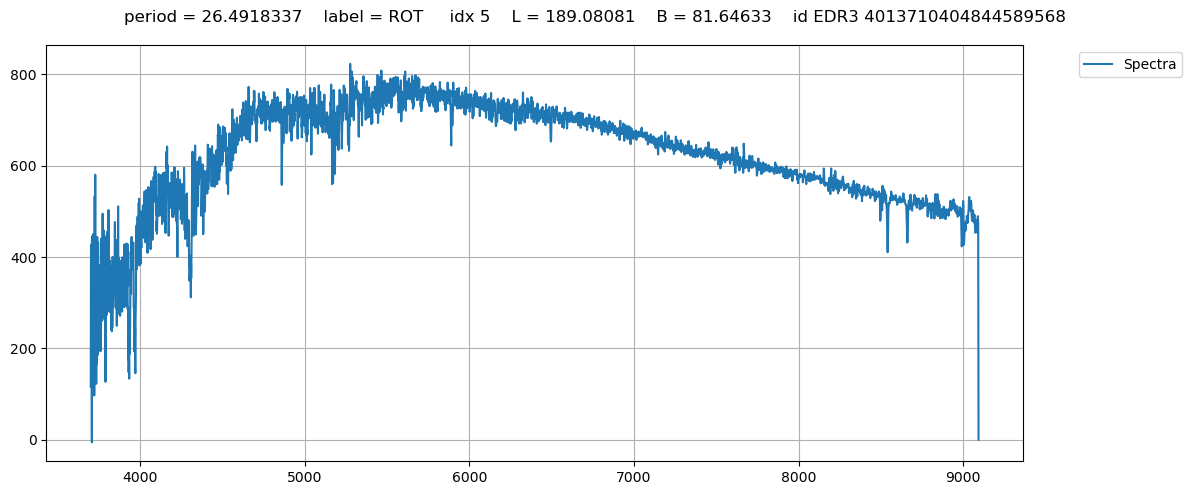

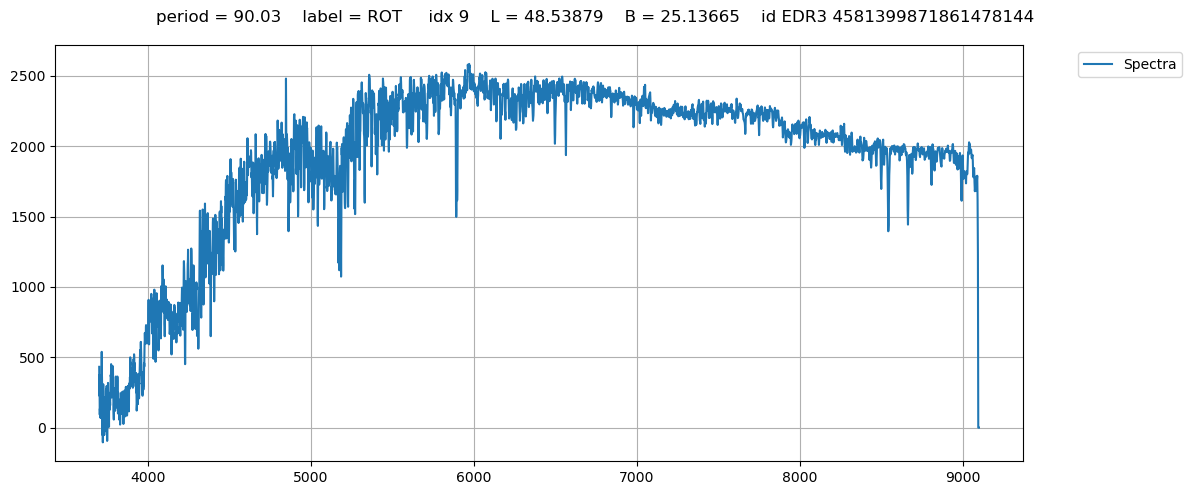

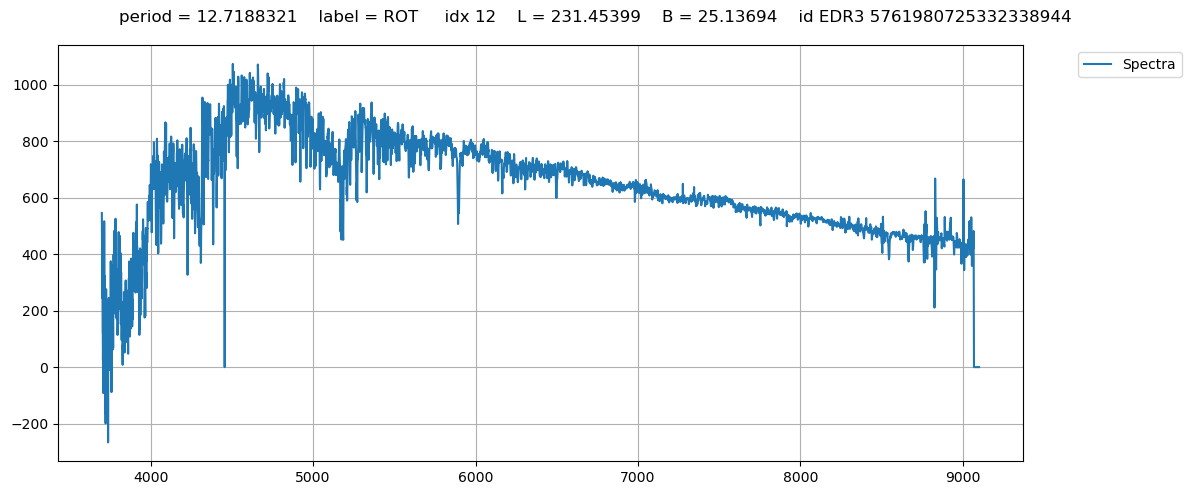

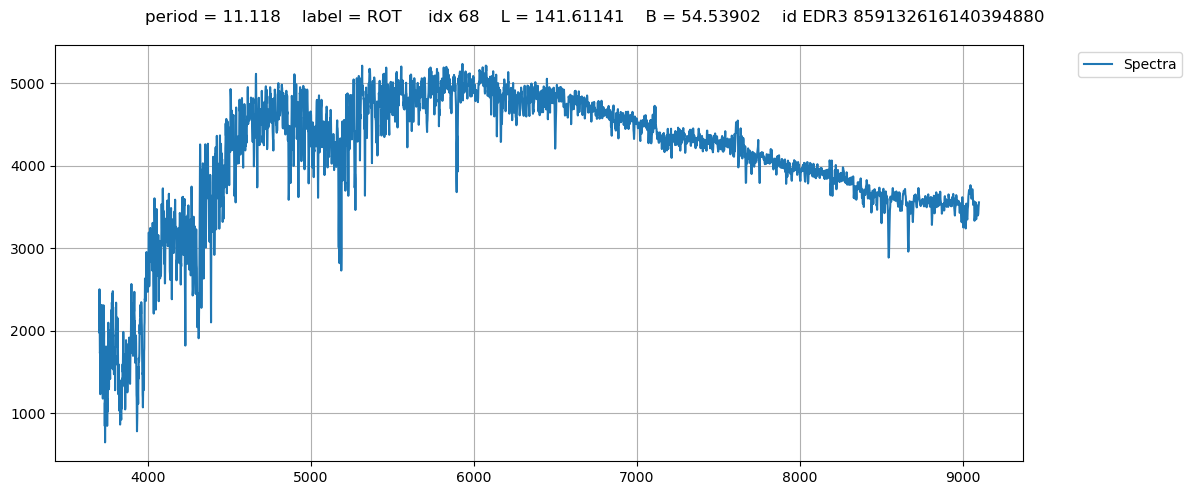

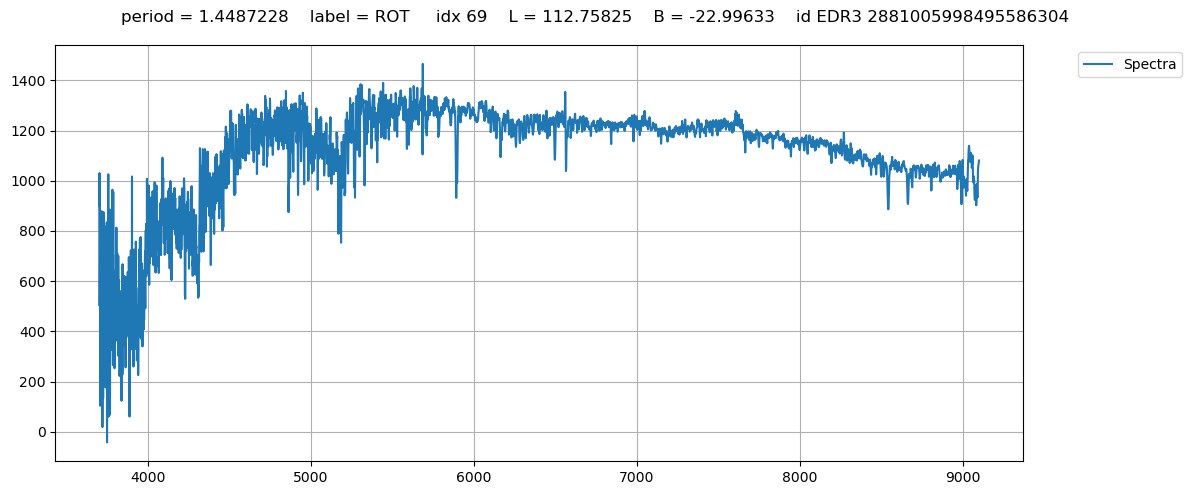

In [433]:
for i in range(5):
    plot_spectra_rs(train_dataset, rs_indices[rs_bin == 0][i])

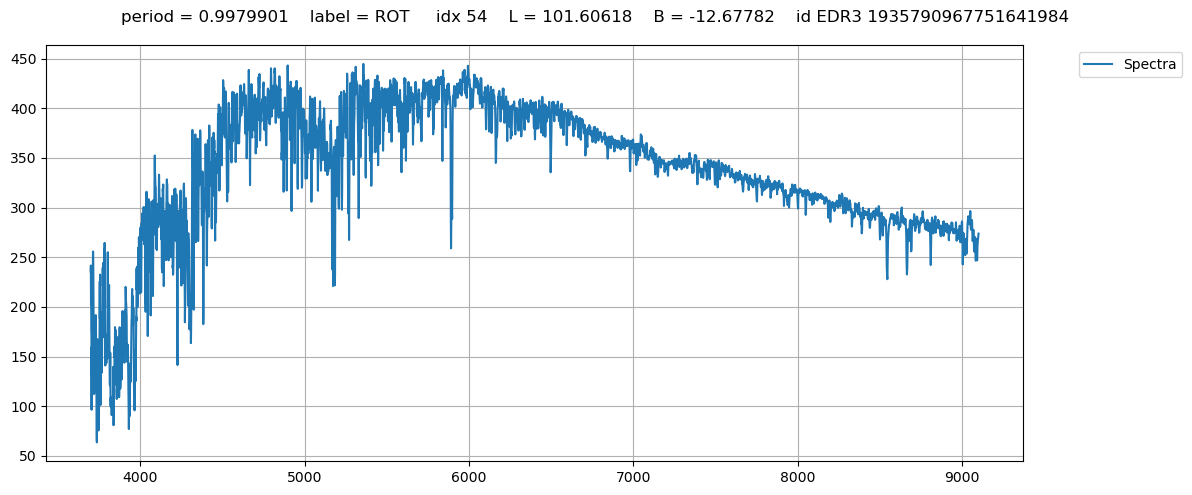

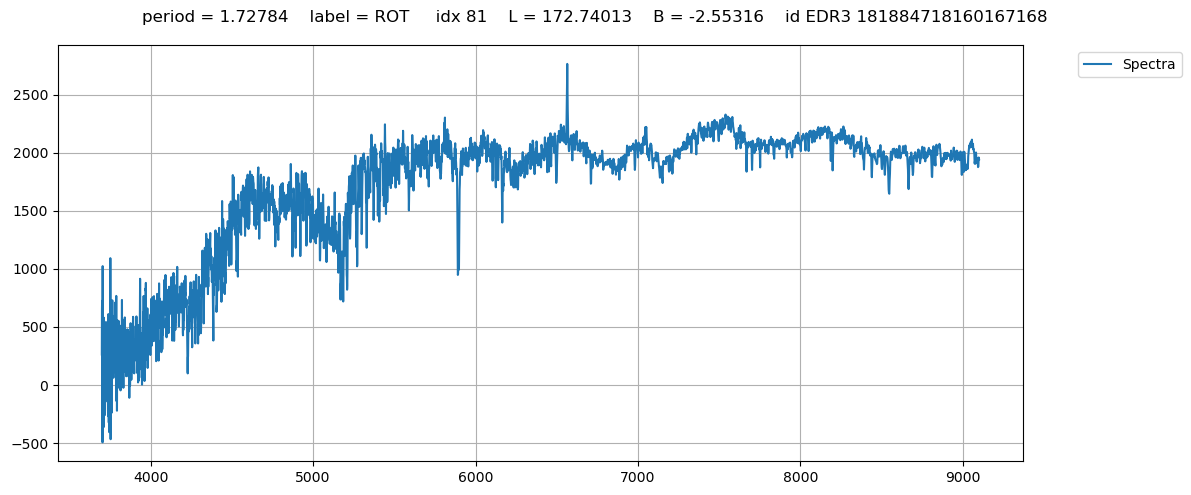

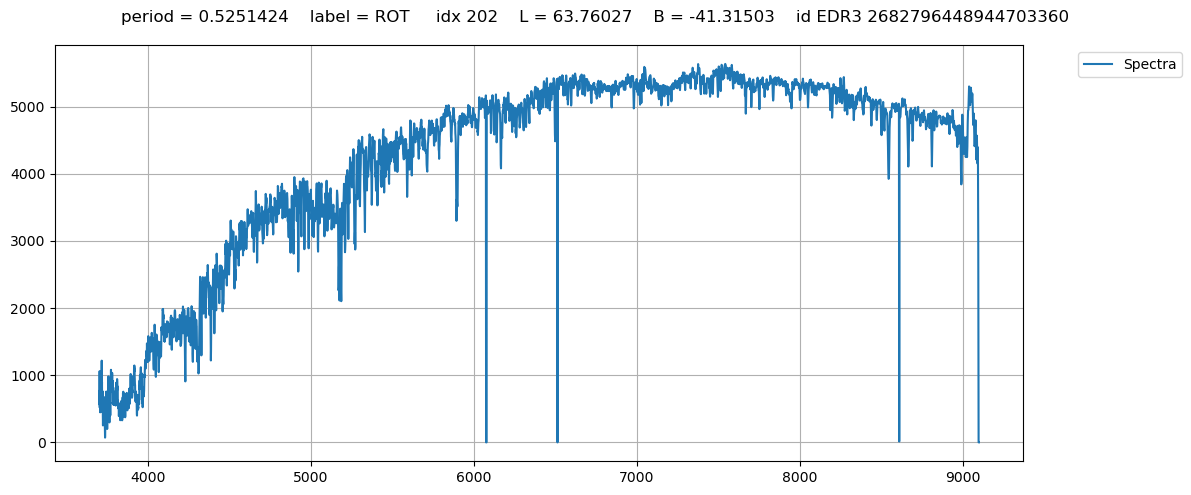

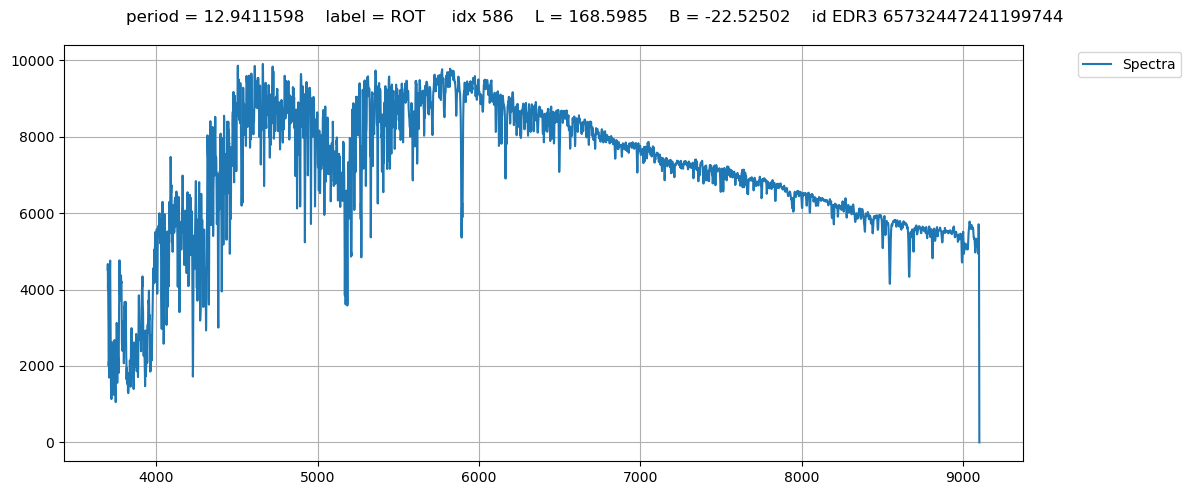

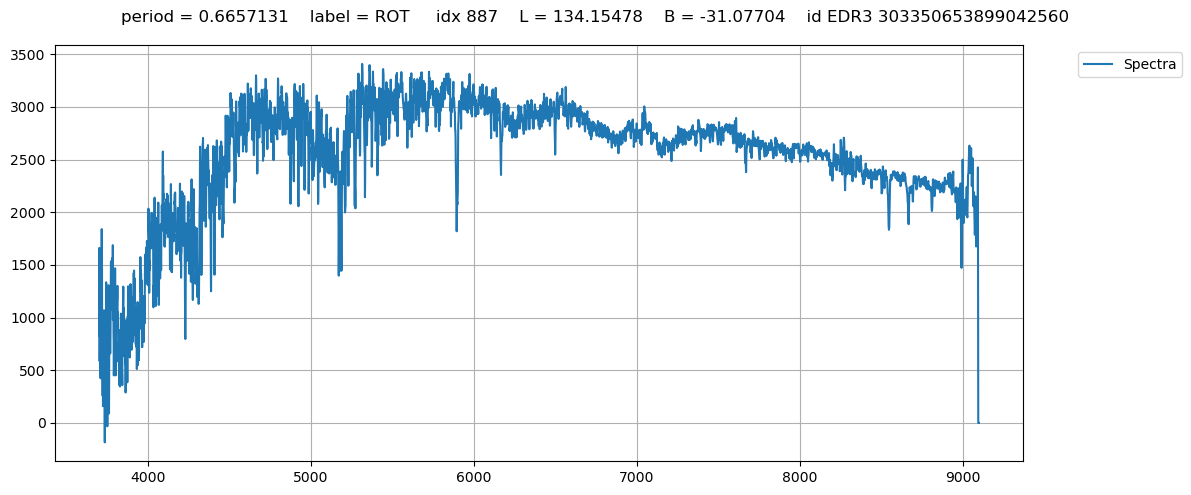

In [434]:
for i in range(5):
    plot_spectra_rs(train_dataset, rs_indices[rs_bin == 1][i])

In [149]:
ind = train_labels == target2id['M']
m_ind = np.arange(len(ind))[ind]
m_umap = train_umap[m_ind]
m_bin = np.where(m_umap[:, 1] > 2.3, 1, 0)

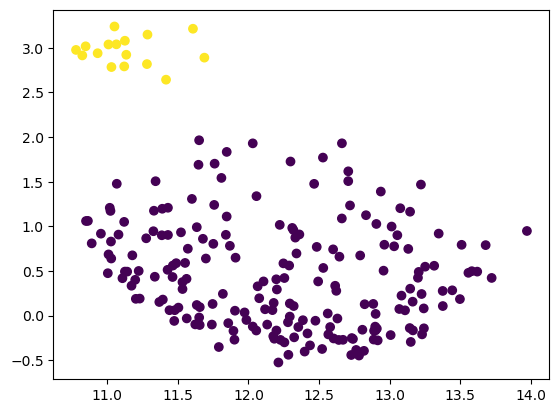

In [144]:
plt.scatter(m_umap[:, 0], m_umap[:, 1], c=m_bin)

In [330]:
len(m_ind[m_bin == 0])

200

In [322]:
for el in train_dataset.df.loc[m_ind[m_bin == 1], 'id']:
    print(el)

EDR3 872296282883209344
EDR3 342977194698972928
EDR3 3089461892611624448
EDR3 635892040139785344
EDR3 3359214284368618752
EDR3 635938803743669504
EDR3 1995023961249856896
EDR3 3429801011022038912
EDR3 360192866734187392
EDR3 3419512983797945728
EDR3 3702533805136832128
EDR3 3452607424800795392
EDR3 662279185337050752
EDR3 263516344056616576
EDR3 3113305111497306368
EDR3 163477484762516992


In [329]:
for el in train_dataset.df.loc[m_ind[m_bin == 0]]['name']:
    print(f"'{el.split('-')[-1][1:]}', ", end='')

'J182629.57+090659.3', 'J182531.12+174030.2', 'J045720.55+532738.4', 'J193613.74+392643.2', 'J183106.36+090131.8', 'J040612.20+535629.4', 'J185950.62+452139.5', 'J084041.40+423633.3', 'J000529.29+525257.4', 'J043511.72+391948.2', 'J211424.18+162824.3', 'J044627.27+373310.5', 'J053033.81+330022.0', 'J052749.29+064638.6', 'J081105.33+040137.9', 'J053505.18+222510.4', 'J231759.59+464512.3', 'J185905.15+190324.5', 'J065056.63+290156.4', 'J183600.03+064248.7', 'J004542.15+461157.8', 'J011030.43+450611.4', 'J192008.66+414058.8', 'J194233.34+415617.0', 'J182913.65+111428.9', 'J043105.04+501026.0', 'J204306.73+300038.2', 'J023951.15+555352.3', 'J204541.63+364412.7', 'J184143.69+081136.9', 'J072258.86+372415.2', 'J121846.58+233843.2', 'J233202.58+243842.6', 'J213526.61+172406.4', 'J205202.81+360758.1', 'J070118.90+383001.8', 'J220342.59+354347.2', 'J035404.46+443354.0', 'J182517.74+113751.0', 'J083737.37+395804.1', 'J125859.78+151121.8', 'J045530.42+305734.5', 'J062233.38+012738.7', 'J050203.44

In [ ]:
J054342.21+290935.5

In [ ]:
2137, 4590, 4605, 4610, 7444, 7758 = C

In [175]:
umap = joblib.load('umap.pkl')
p_umap = umap.transform(train_p_emb[m_ind])
s_umap = umap.transform(train_s_emb[m_ind])
m_umap = umap.transform(train_m_emb[m_ind])

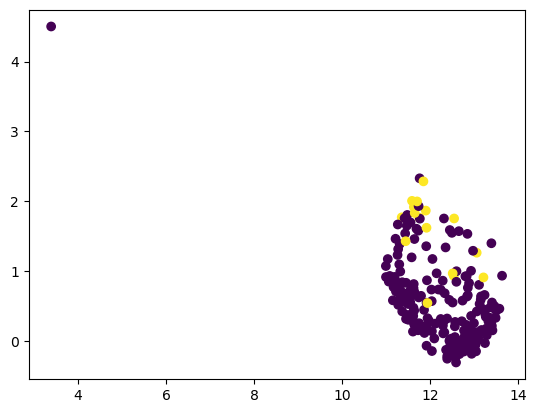

In [176]:
plt.scatter(p_umap[:, 0], p_umap[:, 1], c=m_bin)

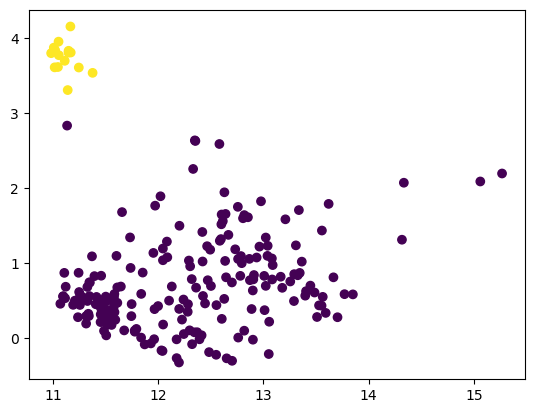

In [177]:
plt.scatter(s_umap[:, 0], s_umap[:, 1], c=m_bin)

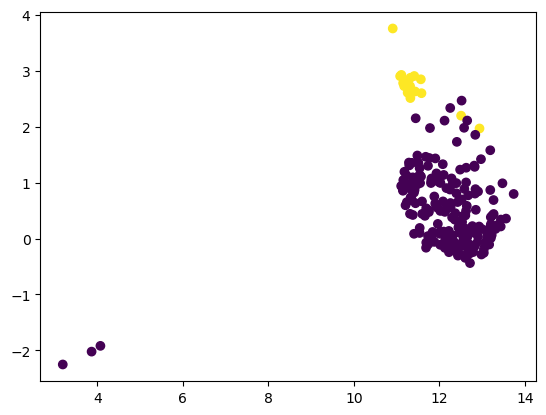

In [178]:
plt.scatter(m_umap[:, 0], m_umap[:, 1], c=m_bin)

In [241]:
train_dataset.meta_cols

['mean_vmag',
 'phot_g_mean_mag',
 'e_phot_g_mean_mag',
 'phot_bp_mean_mag',
 'e_phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'e_phot_rp_mean_mag',
 'bp_rp',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'w1_mag',
 'e_w1_mag',
 'w2_mag',
 'e_w2_mag',
 'w3_mag',
 'w4_mag',
 'j_k',
 'w1_w2',
 'w3_w4',
 'pm',
 'ruwe',
 'l',
 'b']

In [243]:
cols = train_dataset.meta_cols
# cols.remove('pmdec_error')
# cols.remove('e_w1_mag')
# cols.remove('e_w2_mag')
# cols.remove('e_w3_mag')

In [244]:
cols

['mean_vmag',
 'phot_g_mean_mag',
 'e_phot_g_mean_mag',
 'phot_bp_mean_mag',
 'e_phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'e_phot_rp_mean_mag',
 'bp_rp',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'w1_mag',
 'w2_mag',
 'w3_mag',
 'w4_mag',
 'j_k',
 'w1_w2',
 'w3_w4',
 'pm',
 'ruwe',
 'l',
 'b']

1.0


[Text(0.6666666666666666, 0.9, 'j_k <= 2.088\ngini = 0.137\nsamples = 216\nvalue = [200, 16]\nclass = 0'),
 Text(0.5555555555555556, 0.7, 'bp_rp <= 2.995\ngini = 0.074\nsamples = 208\nvalue = [200, 8]\nclass = 0'),
 Text(0.6111111111111112, 0.8, 'True  '),
 Text(0.3333333333333333, 0.5, 'j_k <= 1.434\ngini = 0.486\nsamples = 12\nvalue = [5, 7]\nclass = 1'),
 Text(0.2222222222222222, 0.3, 'bp_rp <= 2.856\ngini = 0.278\nsamples = 6\nvalue = [5, 1]\nclass = 0'),
 Text(0.1111111111111111, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]\nclass = 0'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(0.4444444444444444, 0.3, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]\nclass = 1'),
 Text(0.7777777777777778, 0.5, 'phot_bp_mean_mag <= 12.764\ngini = 0.01\nsamples = 196\nvalue = [195.0, 1.0]\nclass = 0'),
 Text(0.6666666666666666, 0.3, 'b <= -25.269\ngini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = 0'),
 Text(0.5555555555555556, 0.1, 'gini = 0.0\nsamples =

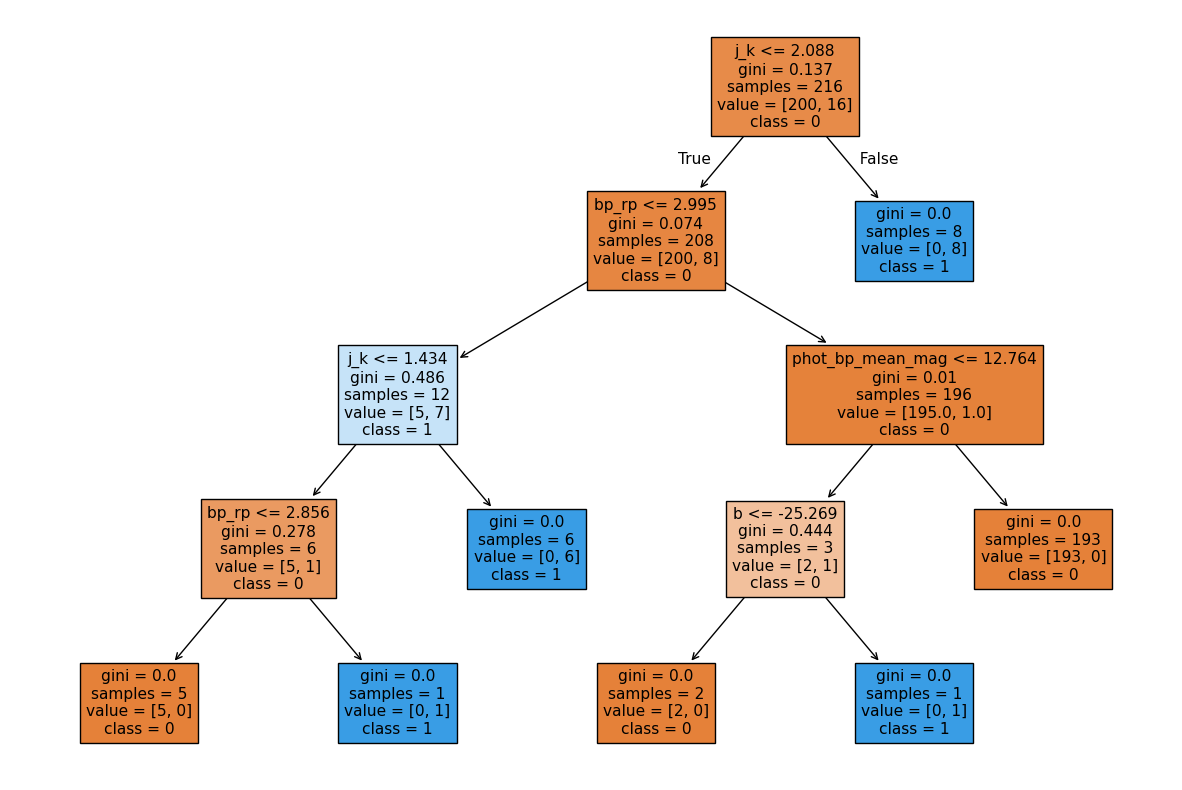

In [245]:
df = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
m_df = df[df['id'].isin(train_dataset.df.iloc[m_ind]['id'])]
m_df = m_df[cols]

clf = DecisionTreeClassifier(random_state=42)
clf.fit(m_df, m_bin)

y_pred = clf.predict(m_df)
print((y_pred == m_bin).sum() / len(m_bin))

plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=m_df.columns, class_names=["0", "1"])

In [ ]:
"""
Spectral     𝐽−𝐾     	   BP-RP 
M-type	     1.2 – 1.6	   2.5 – 3.5
S-type	     1.6 – 2.2	   3.5 – 5.0
C-type	     2.0 – 3.0	   5.0 – 7.0

8 objs: j_k >= 2.088 => C-Type or S-Type
6 objs: 1.434 <= j_k <= 2.088 && bp_rp <= 2.995 => S-Type?
+2 objs
"""

In [ ]:
for el in rs_indices[rs_bin == 0]:
    plot_obj_umap(train_dataset, el, train_umap, train_labels)

# MIRAS FROM THE SMALL CLUSTER

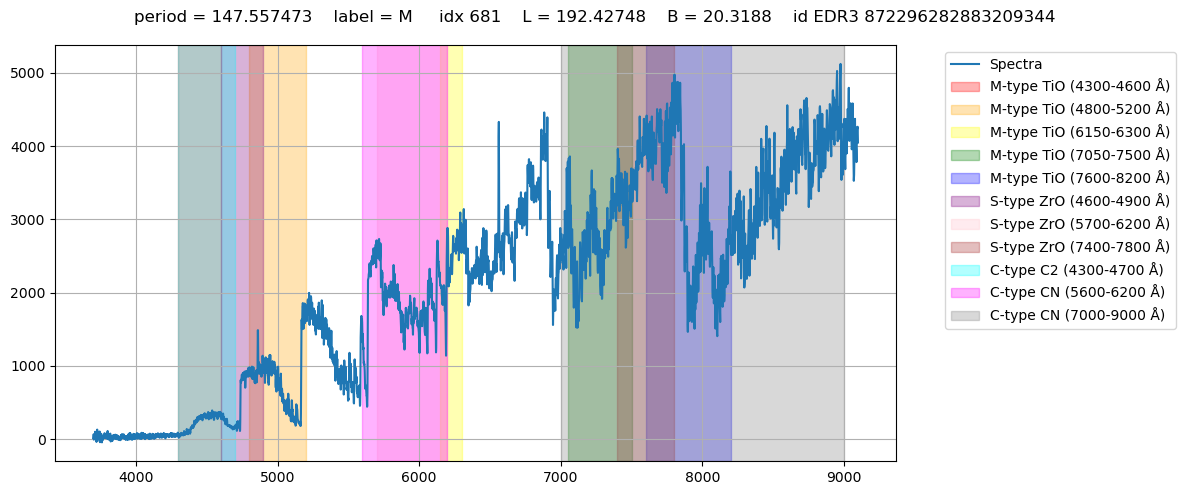

In [260]:
plot_spectra(train_dataset, 681)

In [367]:
def plot_spectra(dataset, idx, mtype='m'):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    l, b = id2lb[el['id']]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    if mtype == 'm':
         
        ax.axvspan(6562.8-1, 6562.8+1, color='cyan', alpha=1.0, label='M-type Hα 6562.8 Å')
        ax.axvspan(4861.3-1, 4861.3+1, color='cyan', alpha=1.0, label='M-type Hβ 4861.3 Å')
        ax.axvspan(4340.5-1, 4340.5+1, color='cyan', alpha=1.0, label='M-type Hγ 4340.5 Å')
        ax.axvspan(4101.7-1, 4101.7+1, color='cyan', alpha=1.0, label='M-type Hδ 4101.7 Å')
        
        # ax.axvspan(7149, 7151, color='purple', alpha=1.0, label='M-type TiO band 7150 Å')
        # ax.axvspan(7599, 7601, color='brown', alpha=1.0, label='M-type TiO band 7600 Å')
        # ax.axvspan(8499, 8501, color='pink', alpha=1.0, label='M-type TiO band 8500 Å')
        # ax.axvspan(4300, 4600, color='red', alpha=0.3, label='M-type TiO (4300-4600 Å)')
        # ax.axvspan(4800, 5200, color='orange', alpha=0.3, label='M-type TiO (4800-5200 Å)')
        # ax.axvspan(6150, 6300, color='yellow', alpha=0.3, label='M-type TiO (6150-6300 Å)')
        ax.axvspan(7050, 7300, color='green', alpha=0.3, label='M-type TiO (7050-7350 Å)')
        # ax.axvspan(7600, 8200, color='blue', alpha=0.3, label='M-type TiO (7600-8200 Å)')
    elif mtype == 's':
        ax.axvspan(4600, 4900, color='purple', alpha=0.3, label='S-type ZrO (4600-4900 Å)')
        ax.axvspan(5700, 6200, color='pink', alpha=0.3, label='S-type ZrO (5700-6200 Å)')
        ax.axvspan(7400, 7800, color='brown', alpha=0.3, label='S-type ZrO (7400-7800 Å)')
    else:
        ax.axvspan(4214, 4216, color='yellow', alpha=1.0, label='C-type CN band 4215 Å')
        ax.axvspan(4736, 4738, color='purple', alpha=1.0, label='C-type C2 Swan band 4737 Å')
        ax.axvspan(5164, 5166, color='brown', alpha=1.0, label='C-type C2 Swan band 5165 Å')
        # ax.axvspan(4300, 4700, color='cyan', alpha=0.3, label='C-type C2 (4300-4700 Å)')
        # ax.axvspan(5600, 6200, color='magenta', alpha=0.3, label='C-type CN (5600-6200 Å)')
        # ax.axvspan(7000, 9000, color='gray', alpha=0.3, label='C-type CN (7000-9000 Å)')

    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))
    ax.plot(spectra[:, 0], spectra[:, 1], label='Spectra')
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
    ax.grid(True)

    plt.suptitle(f'period = {period}    label = {id2target[label]}     idx {idx}    L = {l}    B = {b}    id {el["id"]}')
    plt.tight_layout()
    plt.show()

In [66]:
len(m_ind[m_bin == 0])

NameError: name 'm_ind' is not defined

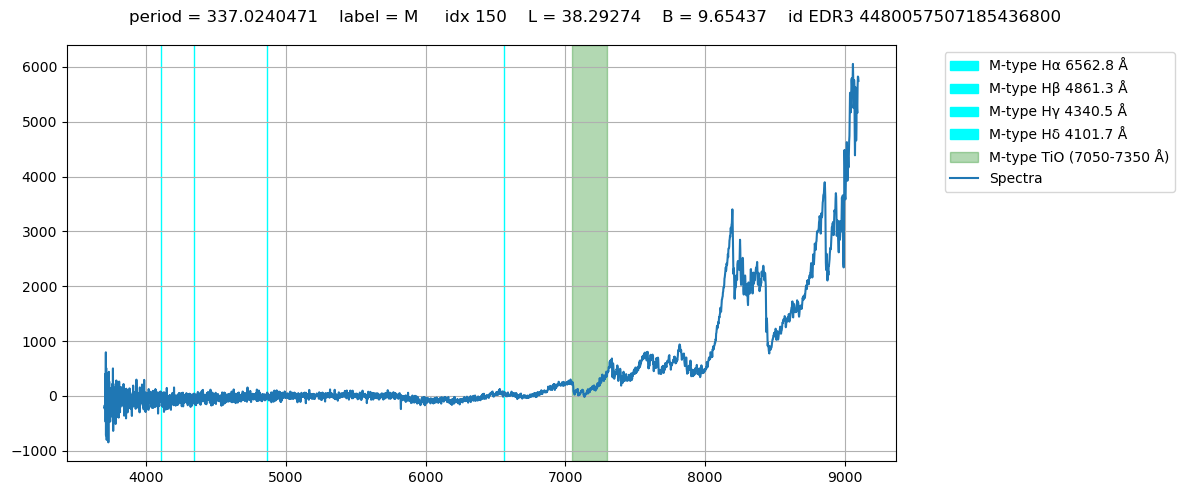

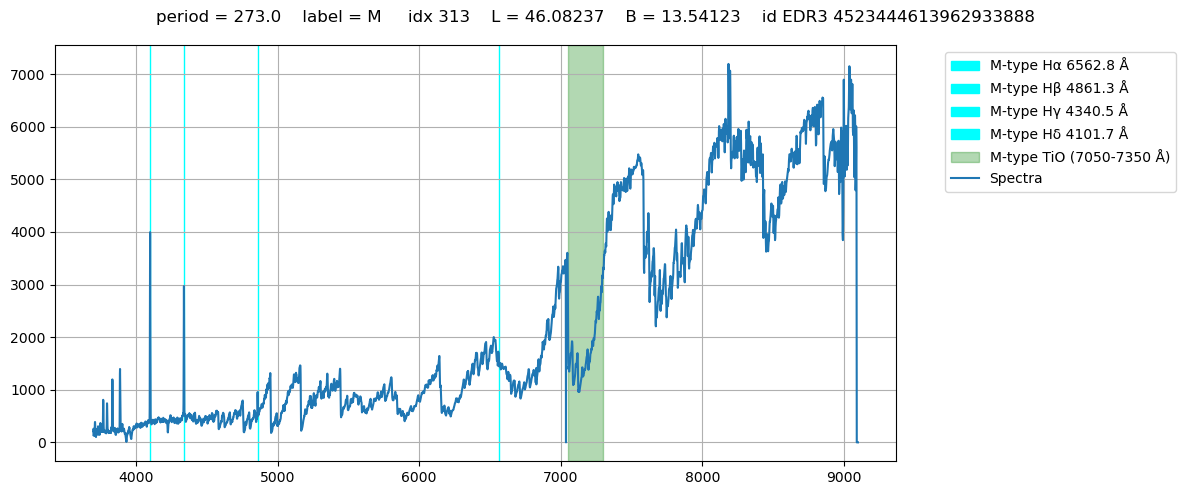

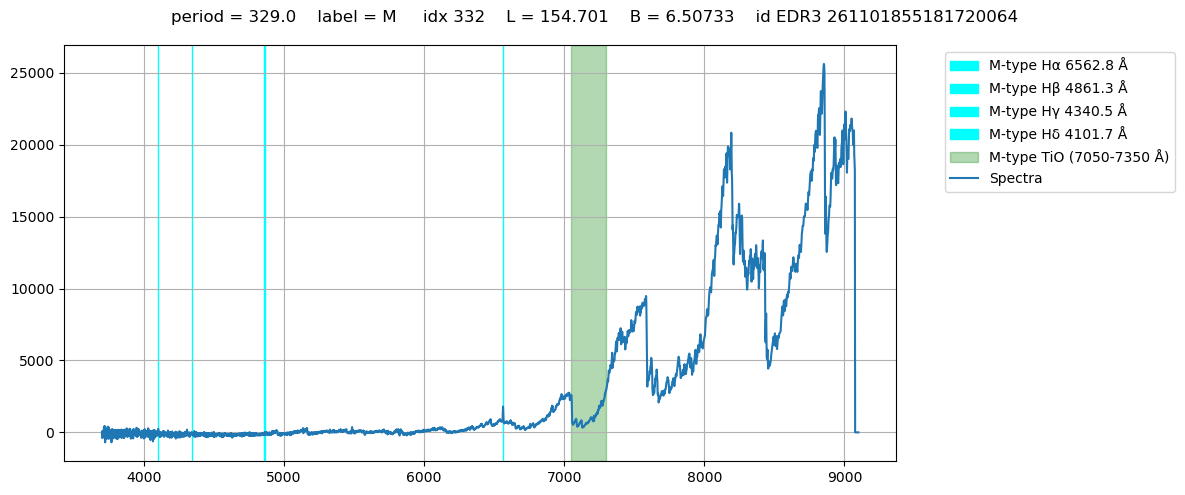

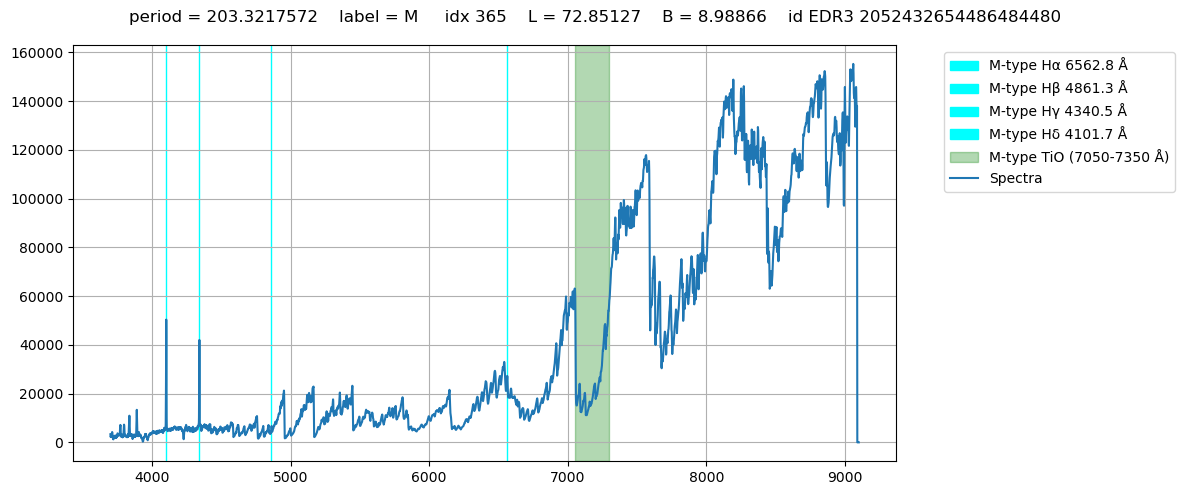

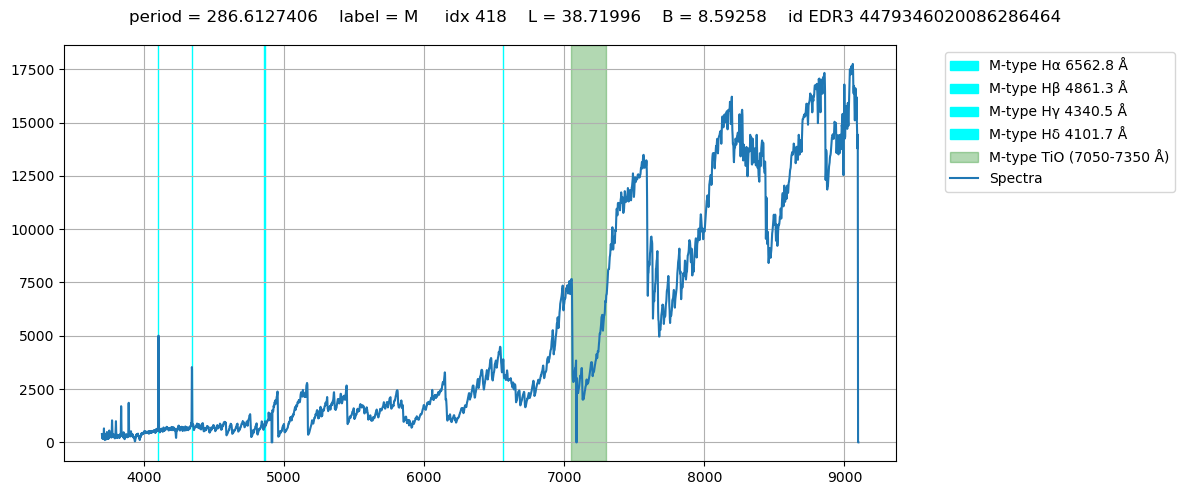

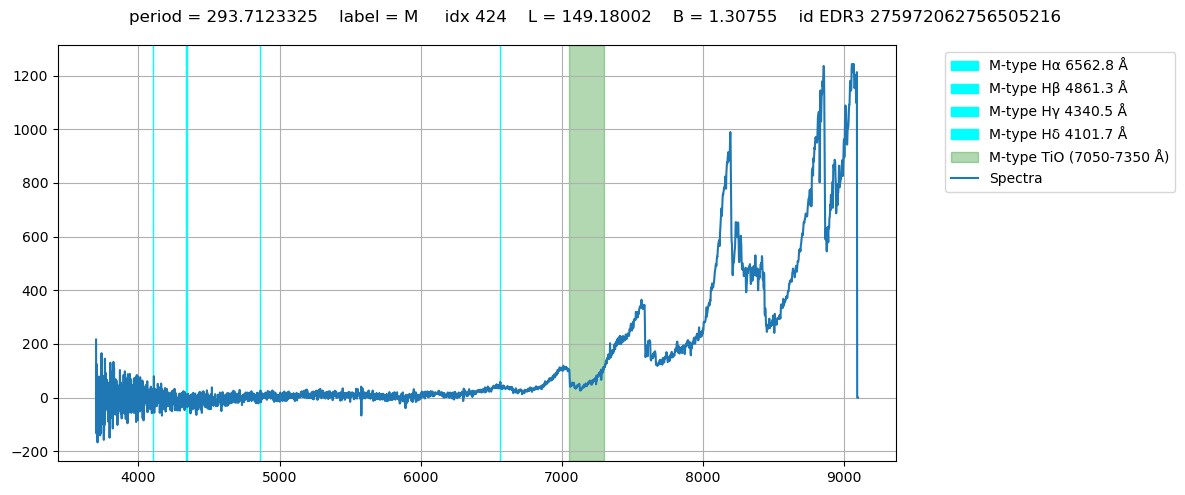

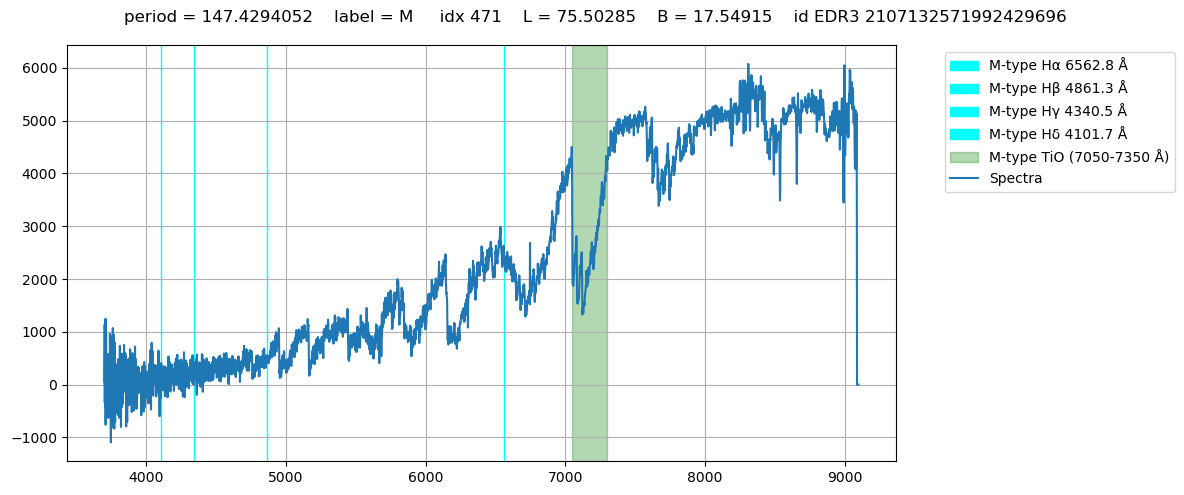

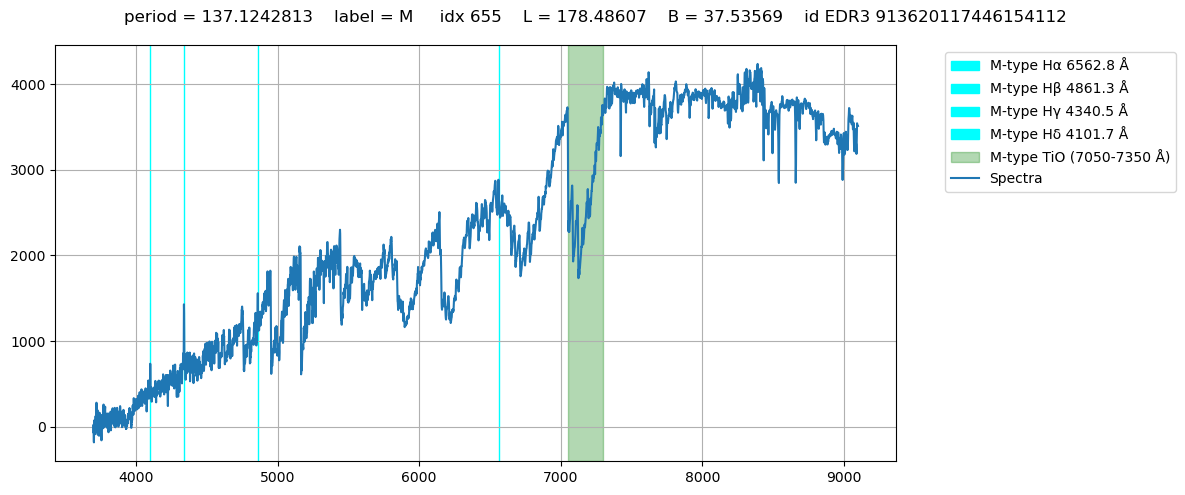

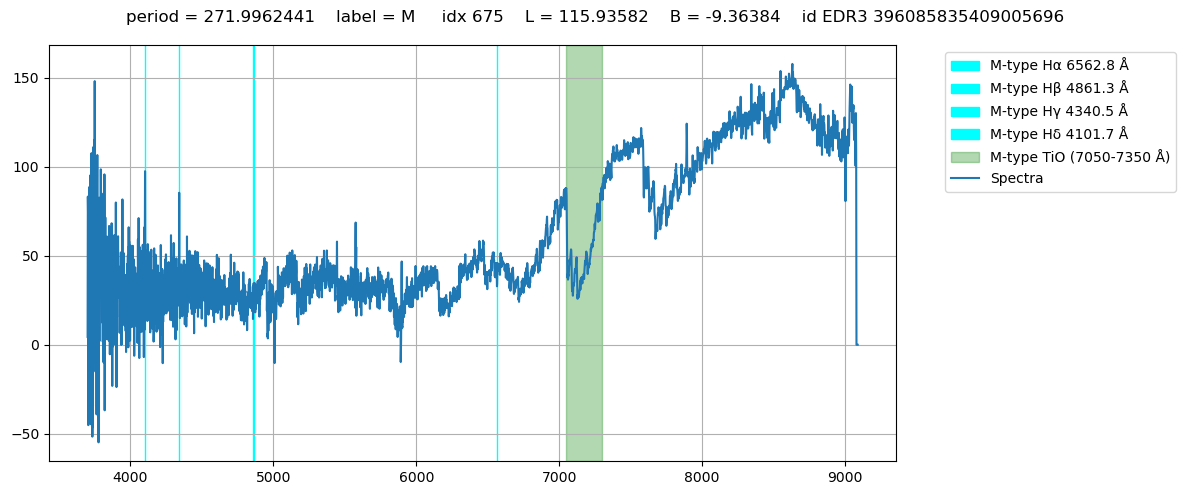

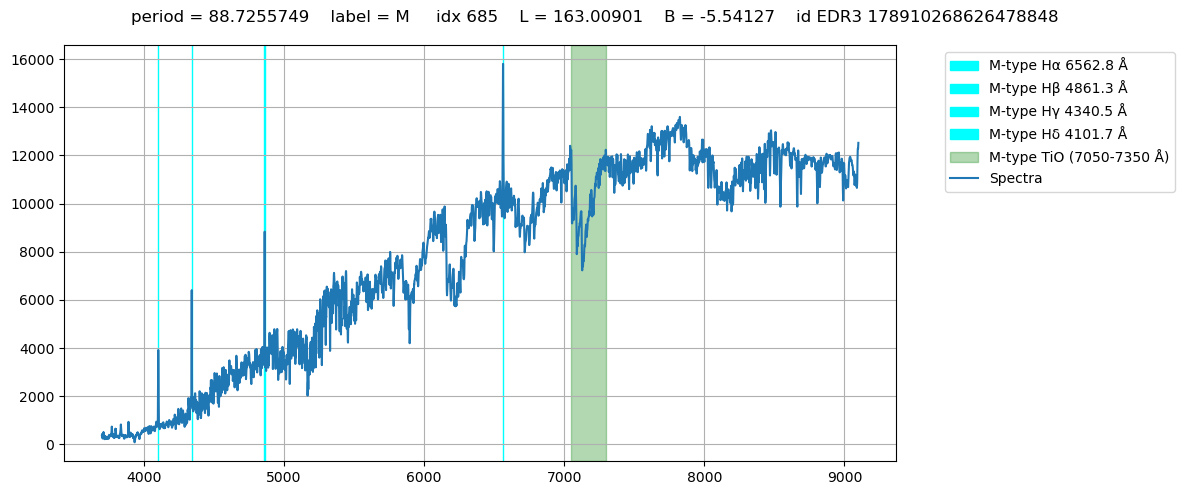

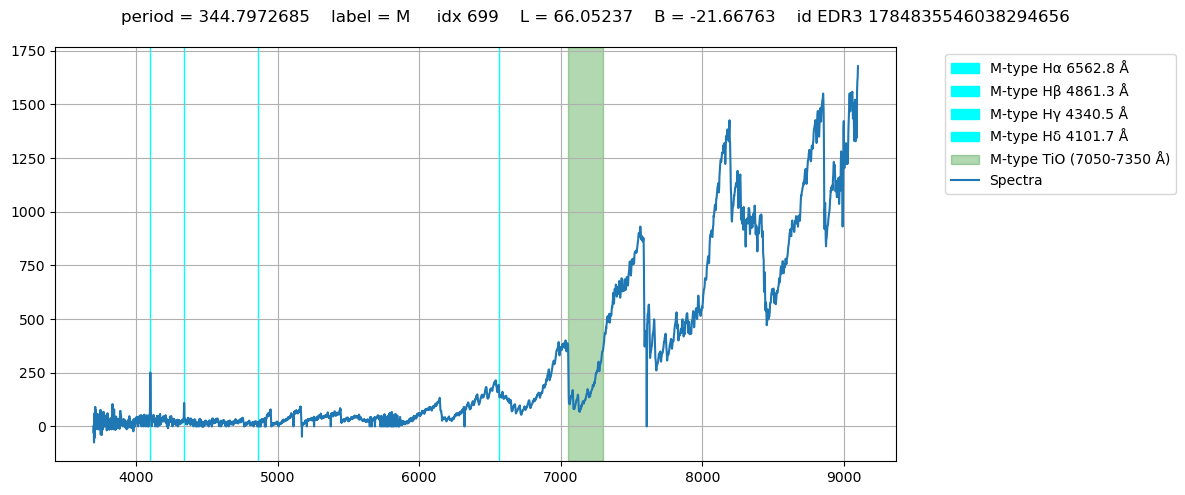

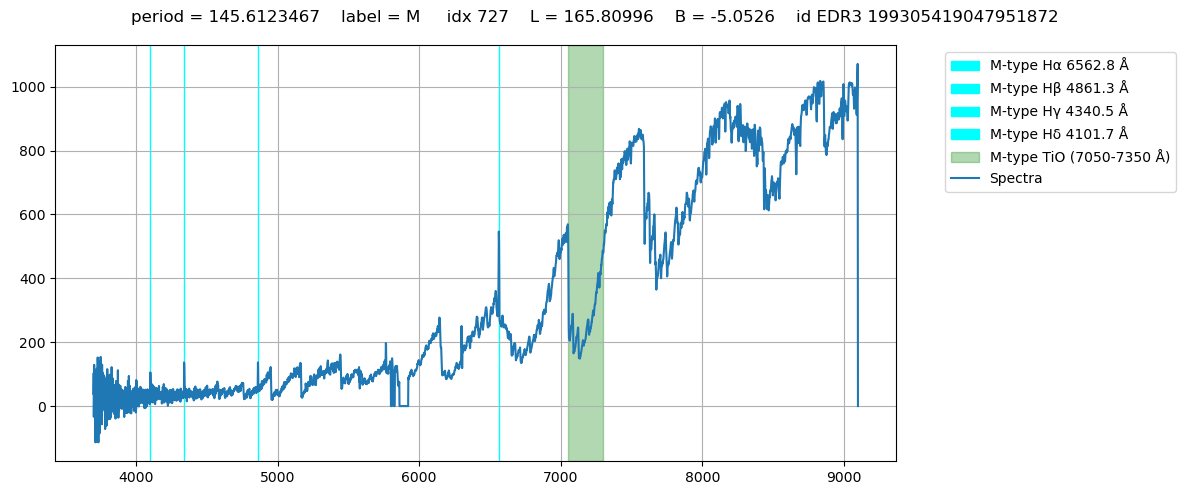

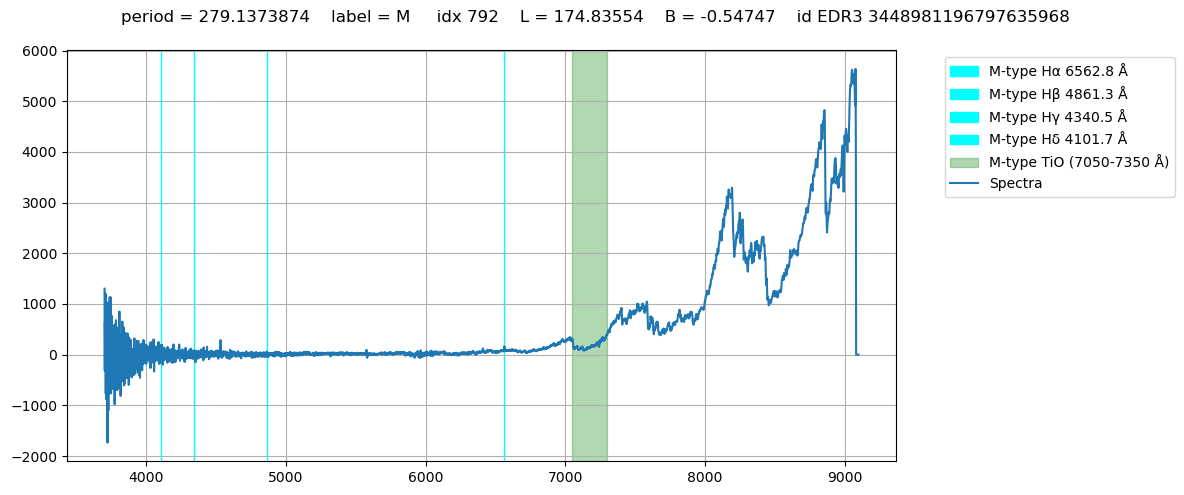

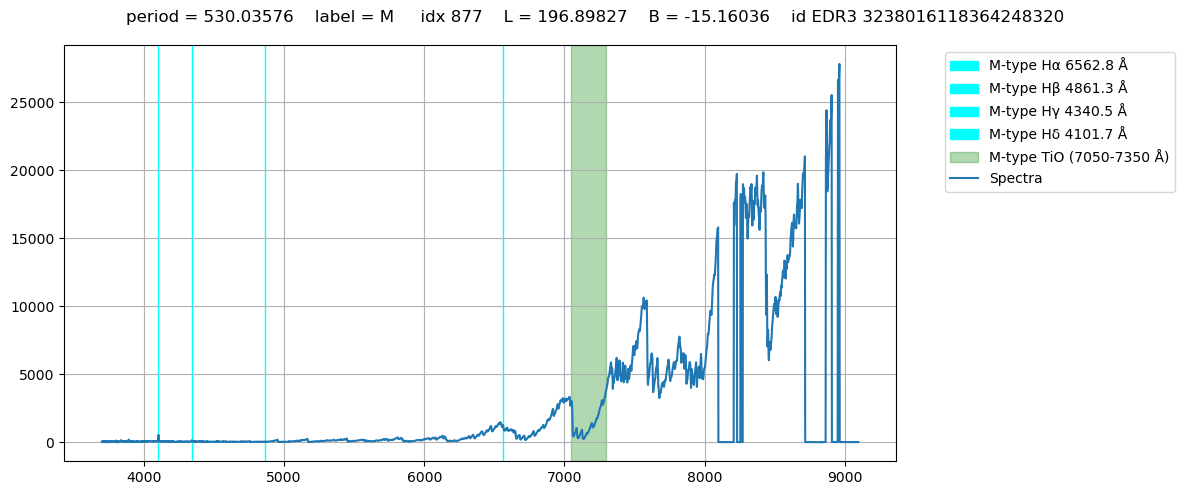

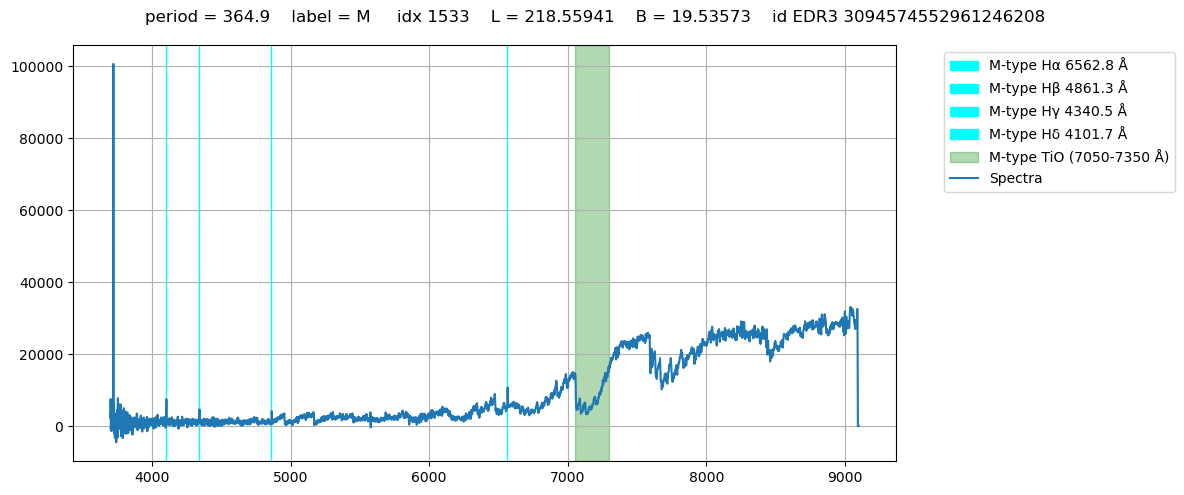

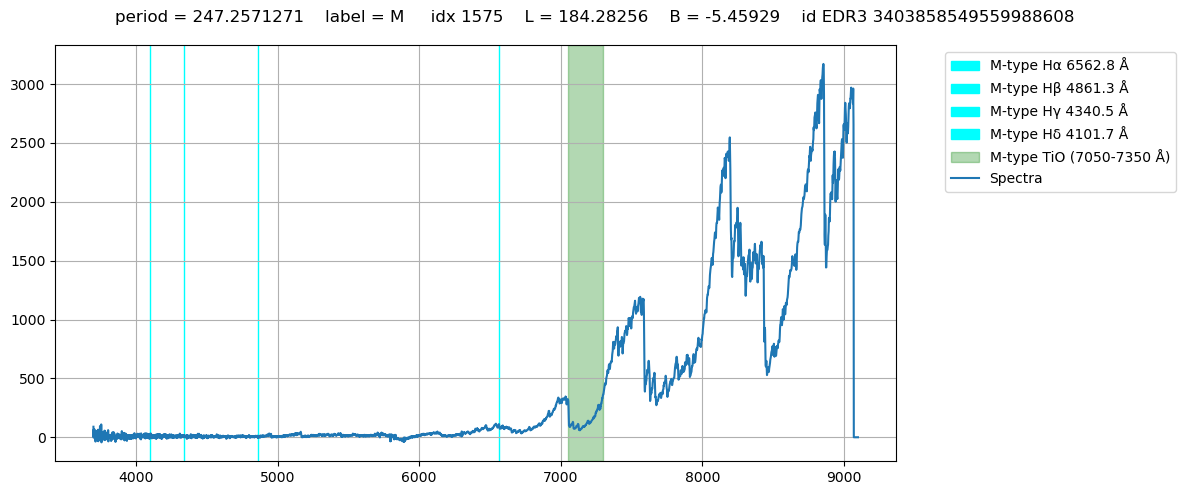

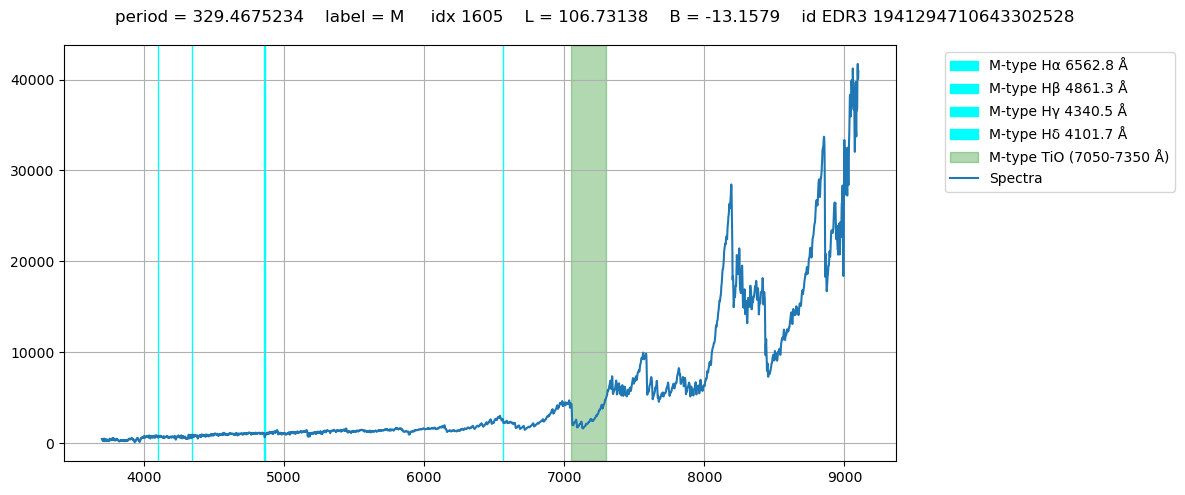

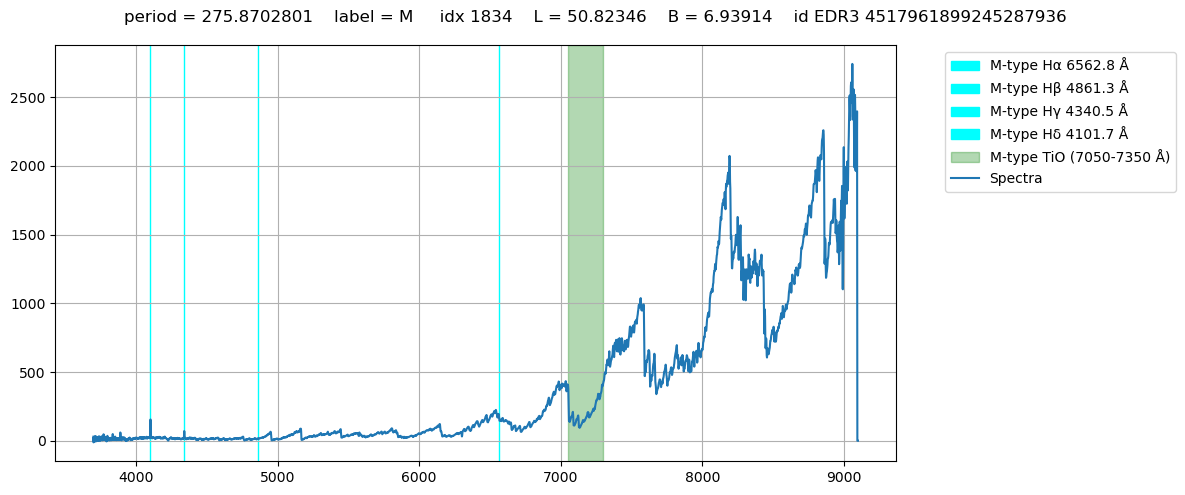

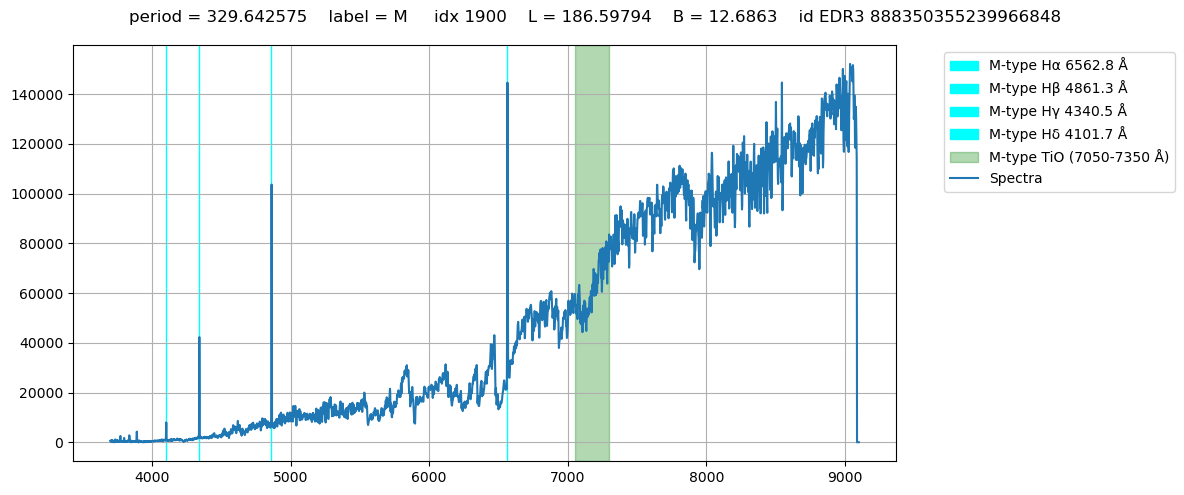

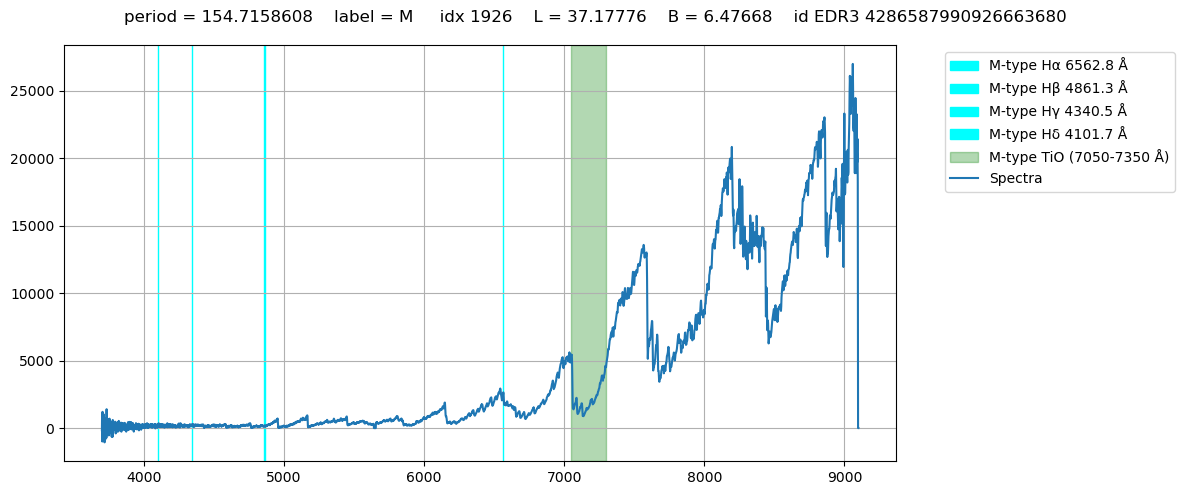

In [368]:
for i in range(20):
    plot_spectra(train_dataset, m_ind[m_bin == 0][i], mtype='m')

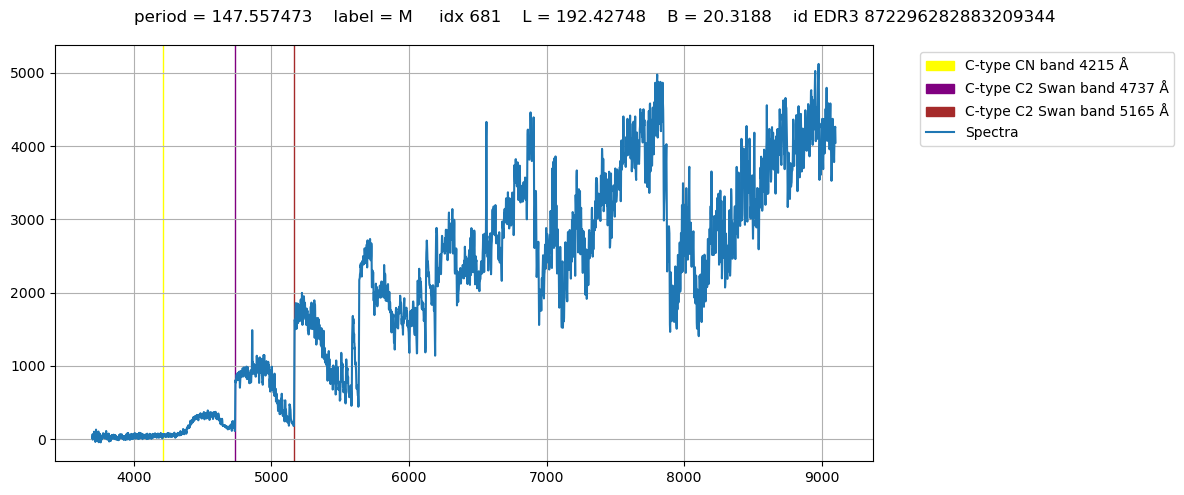

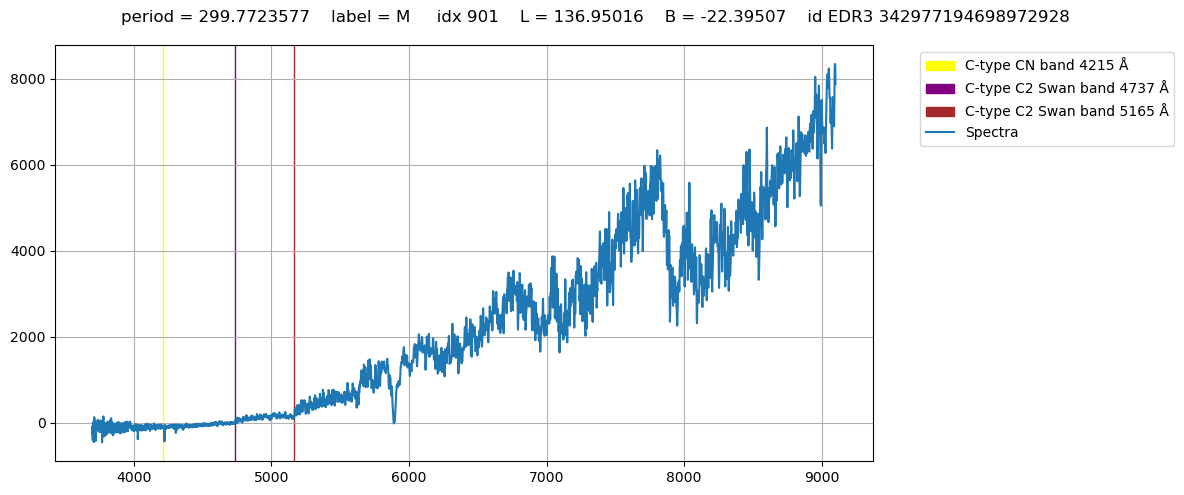

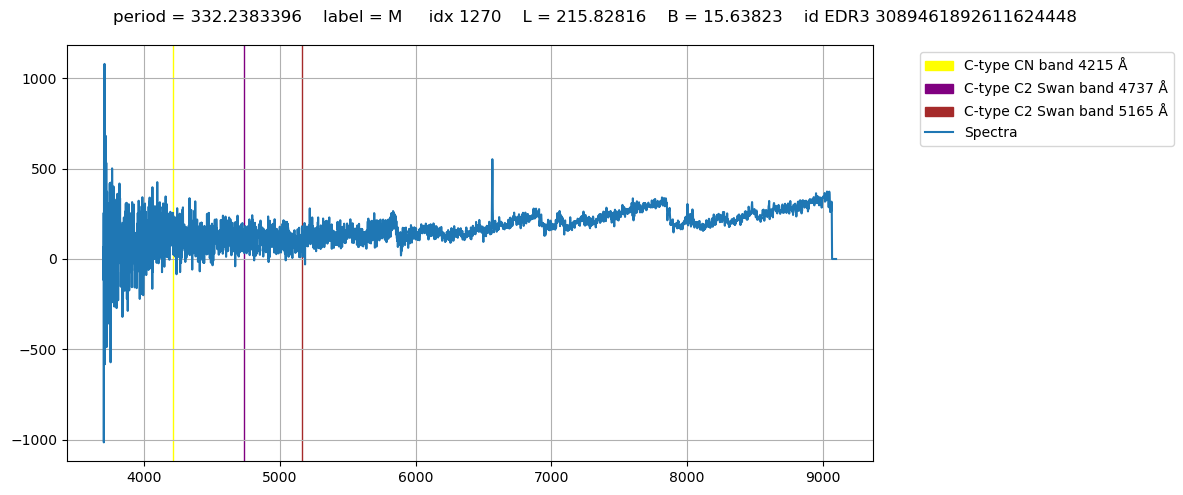

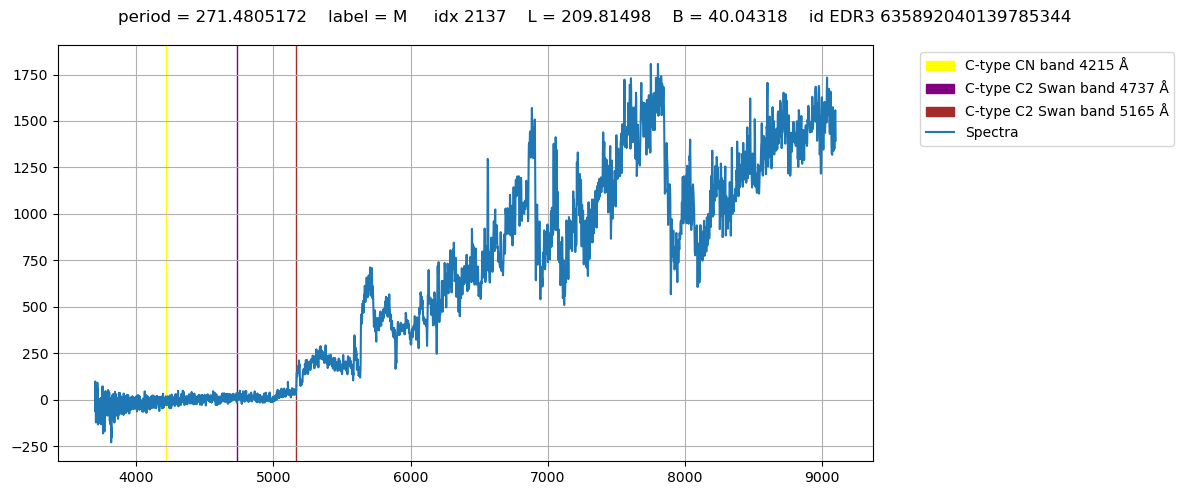

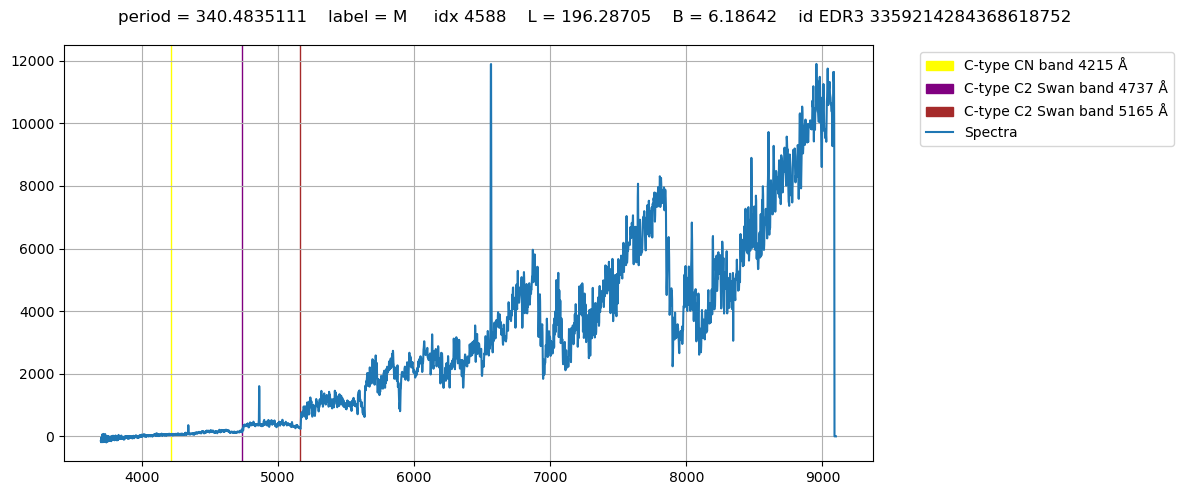

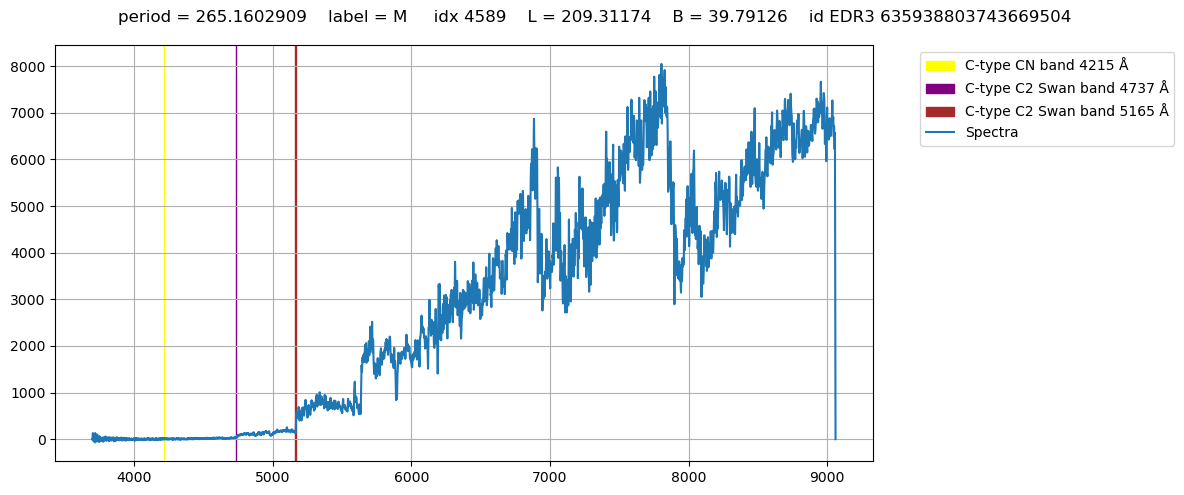

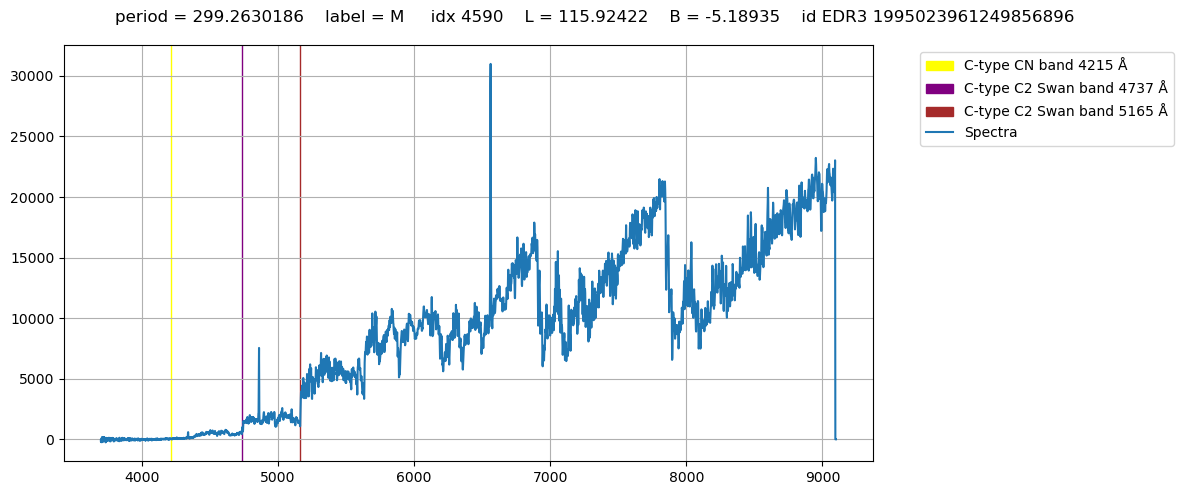

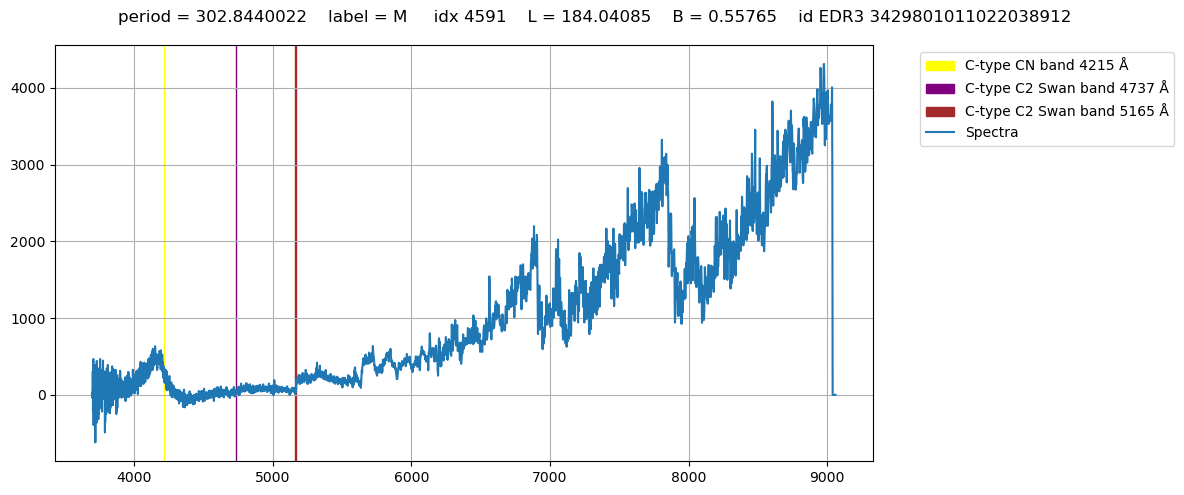

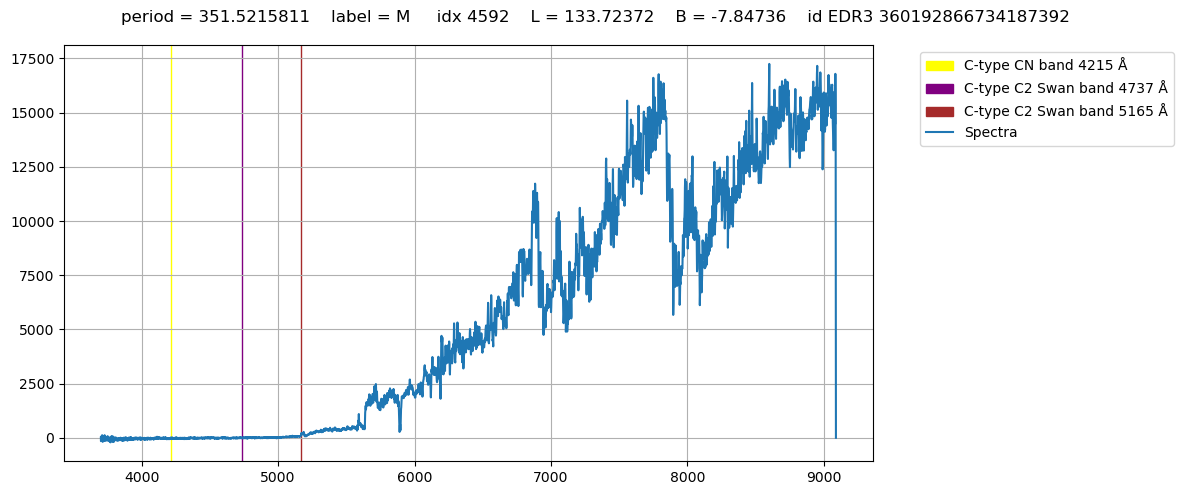

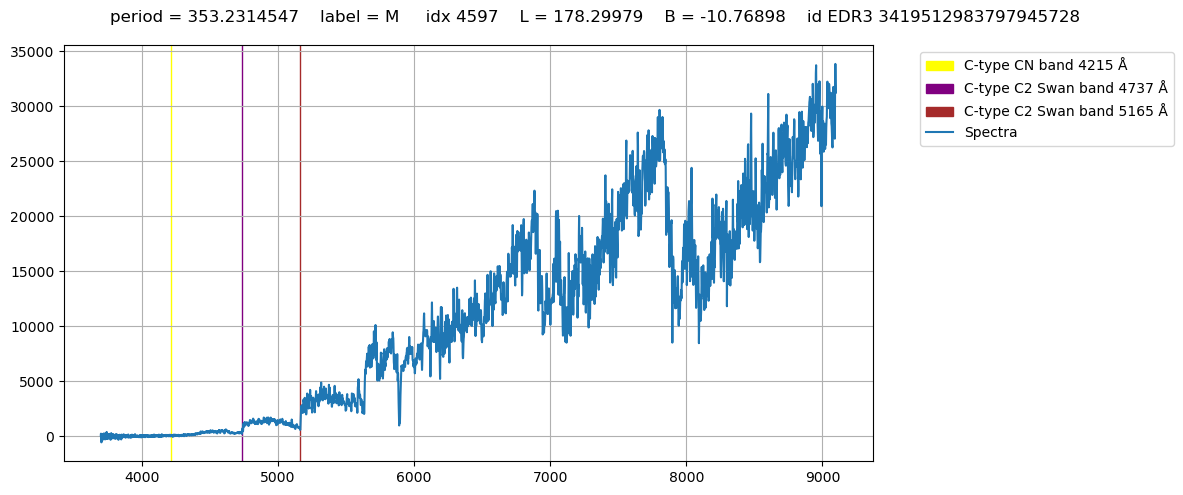

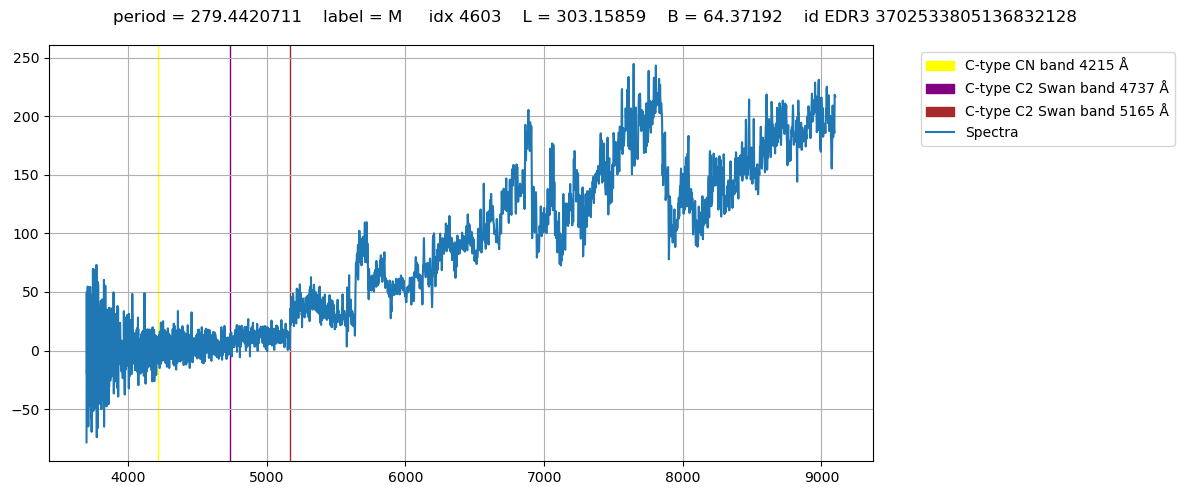

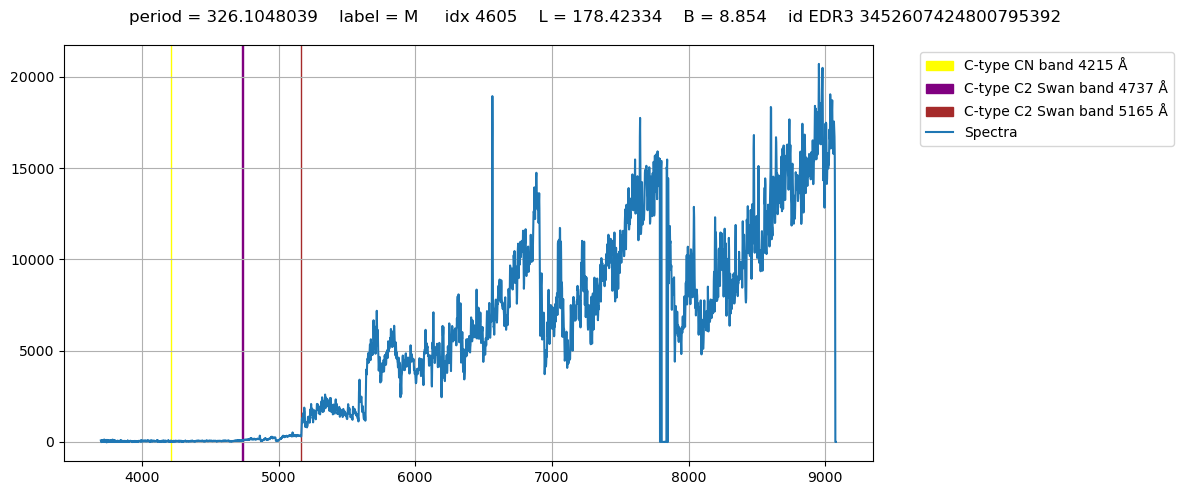

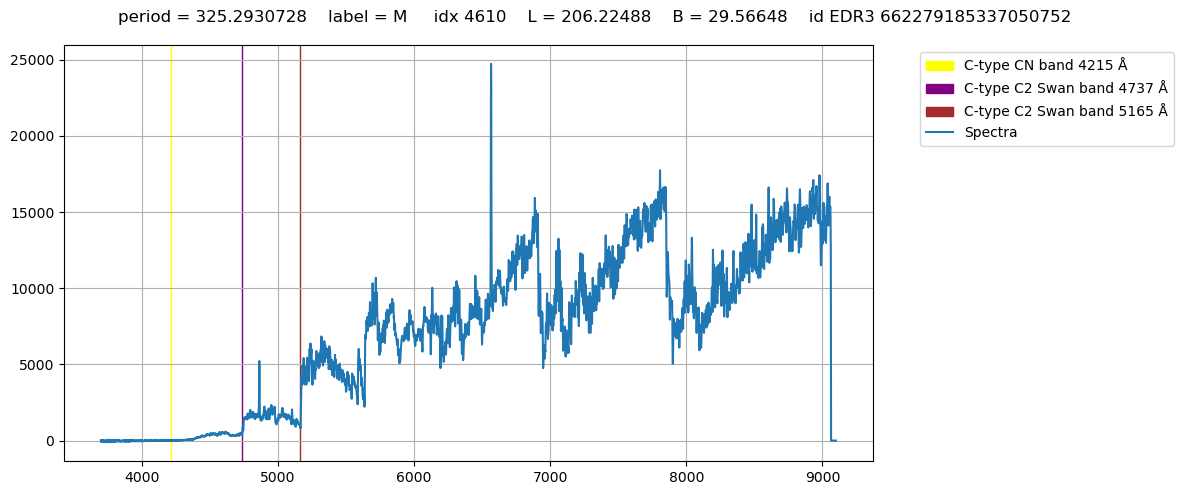

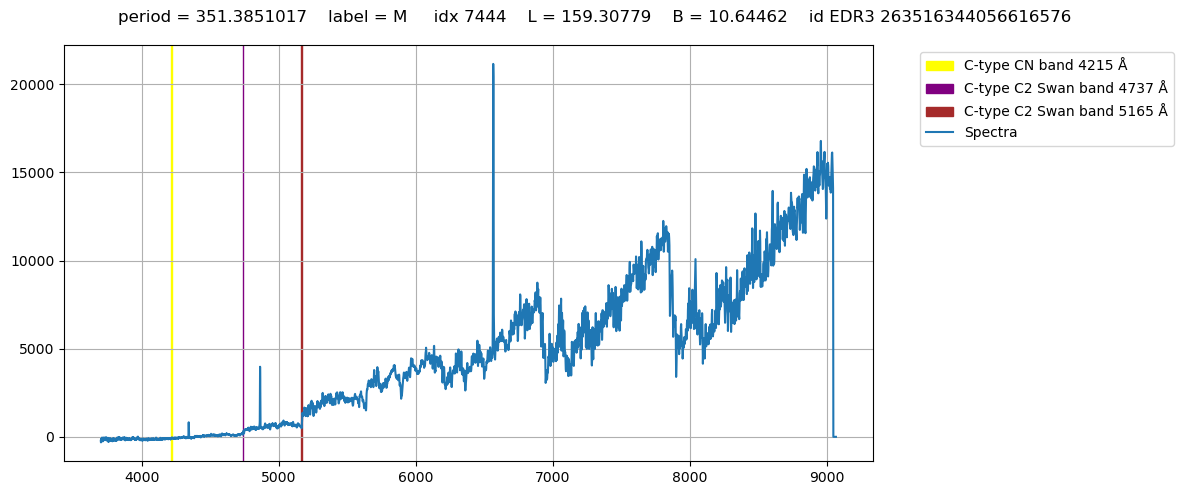

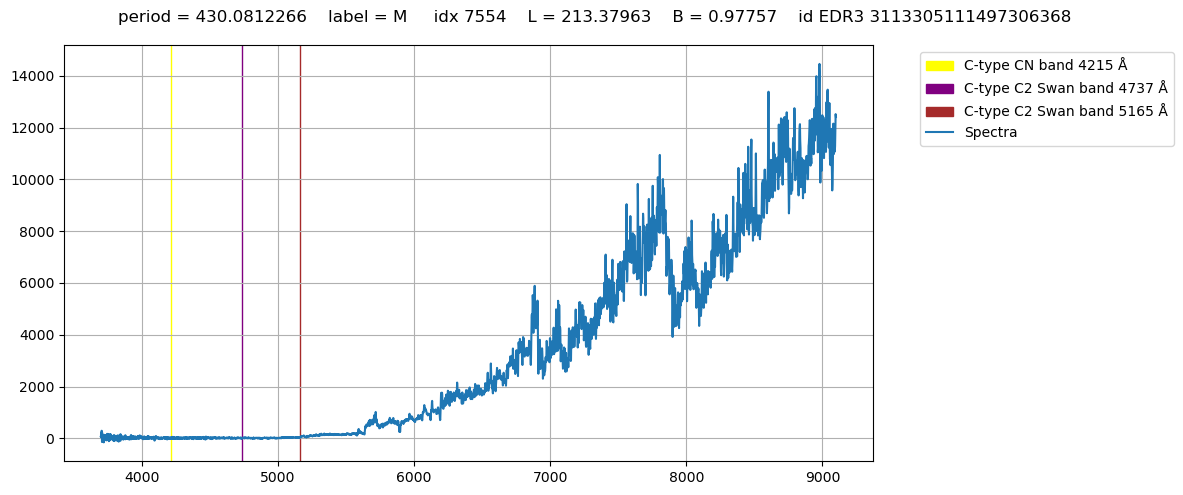

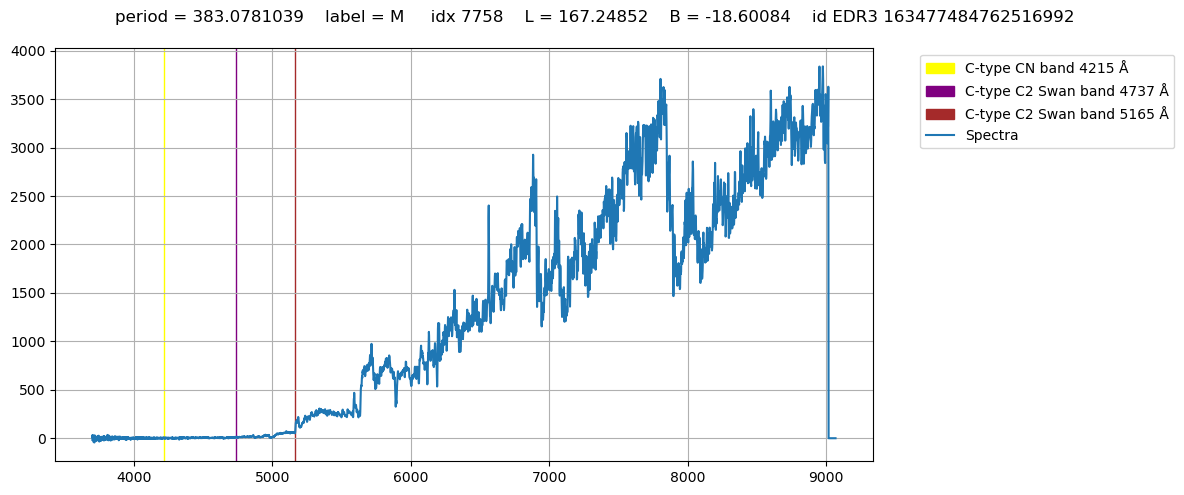

In [348]:
for el in m_ind[m_bin == 1]:
    plot_spectra(train_dataset, el, mtype='c')

In [ ]:
for el in m_ind[m_bin == 1]:
    plot_obj_umap(train_dataset, el, train_umap, train_labels)

# MIRAS FROM THE BIG CLUSTER

In [ ]:
for el in m_ind[m_bin == 0]:
    plot_obj_umap(train_dataset, el, train_umap, train_labels)

# RS BIG CLUSTER

In [ ]:
for el in rs_indices[rs_bin == 0]:
    plot_obj_umap(train_dataset, el, train_umap, train_labels)

# RS SMALL CLUSTER

In [ ]:
for el in rs_indices[rs_bin == 1]:
    plot_obj_umap(train_dataset, el, train_umap, train_labels)